# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
import matplotlib.ticker as mtick

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [3]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [5]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

В датасете есть 25 пропущенных значений (из 11162) по признаку 'balance'. Остальные признаки не имеют явных пропущенных значений.

### Задание 2

In [6]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

В признаке 'job' есть 70 значений, которые обозначены как "unknown". 

### Задание 3

In [7]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance']

0         2 343,00 $ 
1            45,00 $ 
2         1 270,00 $ 
3         2 476,00 $ 
4           184,00 $ 
             ...     
11157         1,00 $ 
11158       733,00 $ 
11159        29,00 $ 
11160           0  $ 
11161           0  $ 
Name: balance, Length: 11162, dtype: object

In [8]:
df['balance'] = df['balance'].str.replace(',00 $', '')
df['balance'] = df['balance'].str.replace('  $', '')
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].astype(float)
df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

In [9]:
round(df['balance'].mean(), 3)

np.float64(1529.129)

### Задание 4

In [10]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
median = df['balance'].median()
df['balance'] = df['balance'].fillna(median)
df['balance']


0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

In [11]:
round(df['balance'].mean(), 3)

np.float64(1526.936)

### Задание 5

In [12]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
mode_job = df['job'].mode()[0]  # 'management' (т.к. у него максимальное количество)
df['job'] = df['job'].replace('unknown', mode_job)
df['job'].value_counts()

job
management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: count, dtype: int64

In [13]:
df['education'].value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

In [14]:
mode_education = df['education'].mode()[0]
mode_education
df['education'] = df['education'].replace('unknown', mode_education)
df['education'].value_counts()

education
secondary    5973
tertiary     3689
primary      1500
Name: count, dtype: int64

In [15]:
# Фильтруем клиентов с самой популярной работой и образованием
filtered_df = df[(df['job'] == mode_job) & 
                 (df['education'] == mode_education)]

# Вычисляем средний баланс и округляем до 3 знаков
average_balance = round(filtered_df['balance'].mean(), 3)

print(f"Средний баланс для группы: {average_balance}")

Средний баланс для группы: 1598.883


### Задание 6

In [16]:
# удалите все выбросы для признака balance
# 1. Рассчитаем квартили и межквартильный размах (IQR)
Q1 = df['balance'].quantile(0.25)  # Первый квартиль (25%)
Q3 = df['balance'].quantile(0.75)  # Третий квартиль (75%)
IQR = Q3 - Q1                      # Межквартильный размах
IQR

np.float64(1576.0)

In [17]:
# 2. Определим границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3. Округлим границы до целых чисел
lower_bound = int(round(lower_bound))
upper_bound = int(round(upper_bound))

print("Нижняя граница:", lower_bound)
print("Вернхняя граница:", upper_bound)

Нижняя граница: -2241
Вернхняя граница: 4063


In [18]:
# 4. Отфильтруем выбросы так, чтобы выбросов в данных не осталось
df_filtered = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]
# обновим нумерацию индекса через reset_index
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10105 entries, 0 to 10104
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.3+ MB


## Часть 2:  Разведывательный анализ

### Задание 1

In [19]:
df_filtered['deposit']

0        yes
1        yes
2        yes
3        yes
4        yes
        ... 
10100     no
10101     no
10102     no
10103     no
10104     no
Name: deposit, Length: 10105, dtype: object

In [20]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# частоты классов
#deposit_counts = df_filtered['deposit'].value_counts(normalize=True) * 100
#print(deposit_counts)
deposit_counts = df_filtered['deposit'].value_counts()
deposit_counts


deposit
no     5424
yes    4681
Name: count, dtype: int64

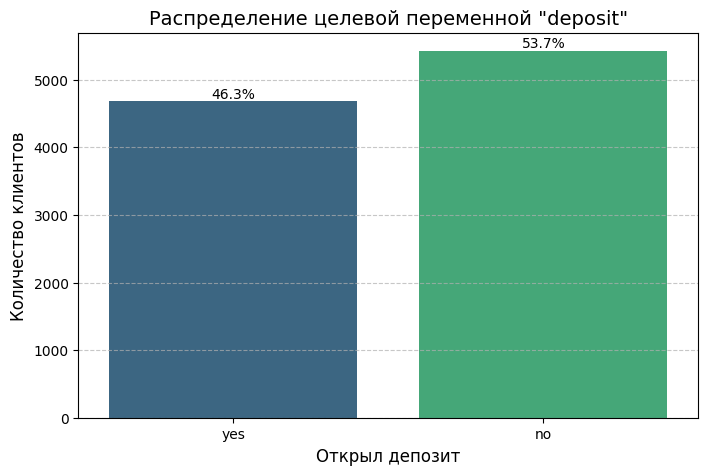

In [21]:
# визуализация
plt.figure(figsize=(8, 5))
sns.countplot(data=df_filtered, x='deposit', palette='viridis')
plt.title('Распределение целевой переменной "deposit"', fontsize=14)
plt.xlabel('Открыл депозит', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
#plt.xticks([0, 1], [ 'Да', 'Нет'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Добавление процентов на столбцы
total = len(df_filtered)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2, height + 50, 
                   f'{height/total*100:.1f}%', ha='center')

plt.show()

На графике видно, что доля клиентов, пожалавших открыть депозит, составляет 46.3% (меньше, чем тех, кто не пожелал открывать депозит).

In [22]:
cross_tab = pd.crosstab(
    index=df_filtered['job'],       # Строки - профессии
    columns=df_filtered['deposit'], # Столбцы - депозит (yes/no)
    margins=True,          # Добавить итоговые суммы (опционально)
    margins_name="Всего"   # Название строки/столбца с итогами
)
cross_tab

deposit,no,yes,Всего
job,,,
admin.,672,574,1246
blue-collar,1155,652,1807
entrepreneur,189,111,300
housemaid,153,99,252
management,1180,1135,2315
retired,231,432,663
self-employed,197,161,358
services,523,345,868
student,81,245,326


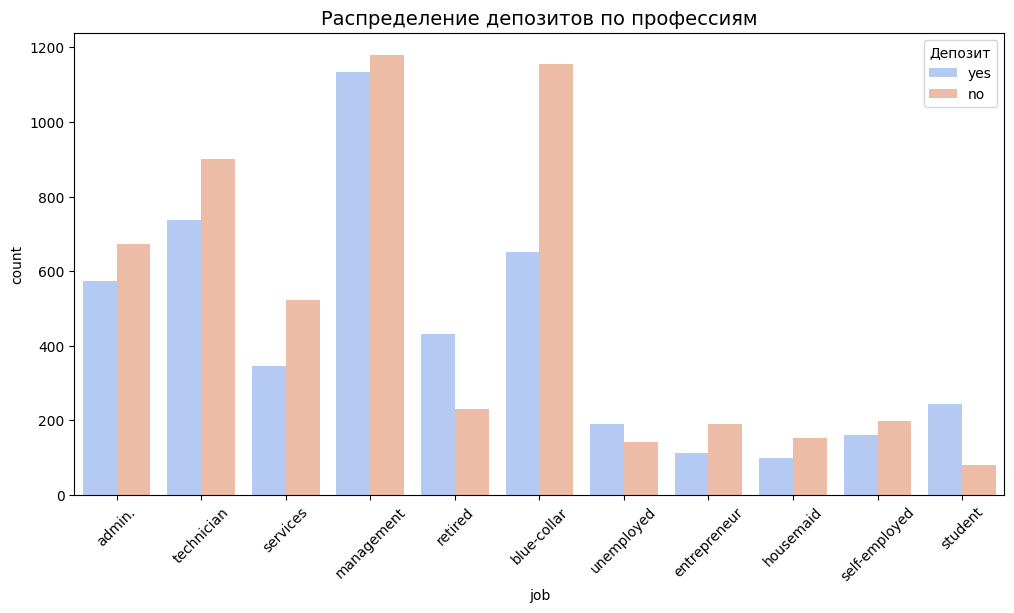

In [23]:
# исследуем влияние разных признаков на признак deposit
# как категориальный признак job влияет на deposit
plt.figure(figsize=(12, 6))
sns.countplot(data=df_filtered, x='job', hue='deposit', palette='coolwarm')
plt.title('Распределение депозитов по профессиям', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Депозит')
plt.show() 

Клиенты с профессиями "management" и "technician" чаще других открывают депозиты.
При этом, клиенты с профессиями "management" и "blue-collar" чаще не открывают депозиты.

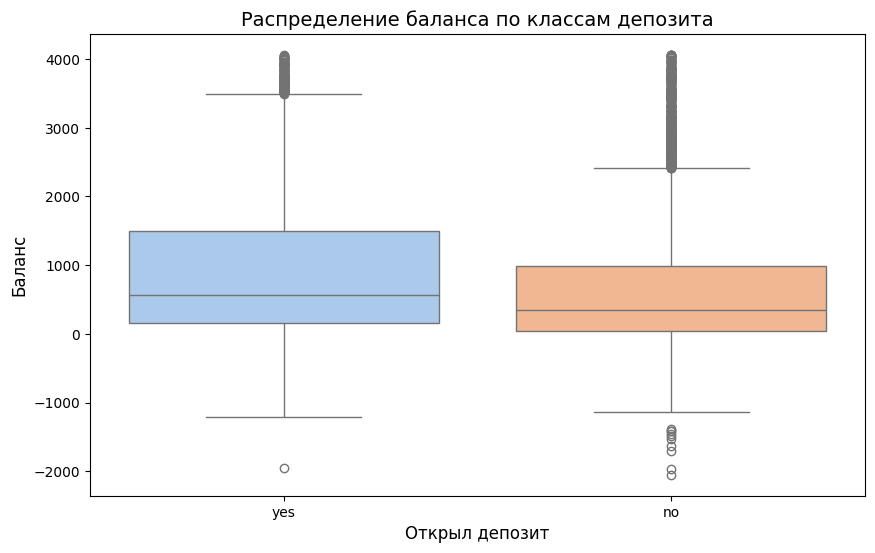

In [24]:
# анализ чилового признака balance для разных классов:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='deposit', y='balance', palette='pastel')
plt.title('Распределение баланса по классам депозита', fontsize=14)
plt.xlabel('Открыл депозит', fontsize=12)
plt.ylabel('Баланс', fontsize=12)
#plt.xticks([0, 1], ['Да', 'Нет'])
plt.show()

Клиенты с депозитами имеют в среднем более высокий баланс.

### Задания 2 и 3

In [25]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#выведем основные описательные статистики для числовых признаков:
numerical_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
desc_stats = df_filtered[numerical_cols].describe().T.round(2)
print(desc_stats)

            count    mean     std     min    25%    50%     75%     max
age       10105.0   40.90   11.73    18.0   32.0   38.0    48.0    95.0
balance   10105.0  807.65  994.15 -2049.0   95.0  445.0  1227.0  4063.0
duration  10105.0  368.74  346.65     2.0  137.0  252.0   490.0  3881.0
campaign  10105.0    2.52    2.71     1.0    1.0    2.0     3.0    43.0
pdays     10105.0   51.32  109.64    -1.0   -1.0   -1.0     2.0   854.0
previous  10105.0    0.82    2.24     0.0    0.0    0.0     1.0    58.0


In [26]:
# Каков максимальный возраст клиента банка?
max_age = df_filtered['age'].max()
print(f"Максимальный возраст клиента: {max_age} лет")

Максимальный возраст клиента: 95 лет


In [27]:
# Какова минимальная продолжительность разговора с клиентом банка? (в секундах)
min_duration = df_filtered['duration'].min()
print(f"Минимальная продолжительность разговора: {min_duration} секунд(ы)")

Минимальная продолжительность разговора: 2 секунд(ы)


**Наблюдения (выводы):**

Демография: Основные клиенты — 30–50 лет, баланс до 1200, мало предыдущих контактов.

Аномалии:
- Отрицательные балансы (-2049 $ - долги).
- Звонки длительностью 2 секунды и 65 минут (хотя в среднем звонки длились от 2  до 8 минут)
- Клиенты с 43 контактами (перебор в маркетинге?).

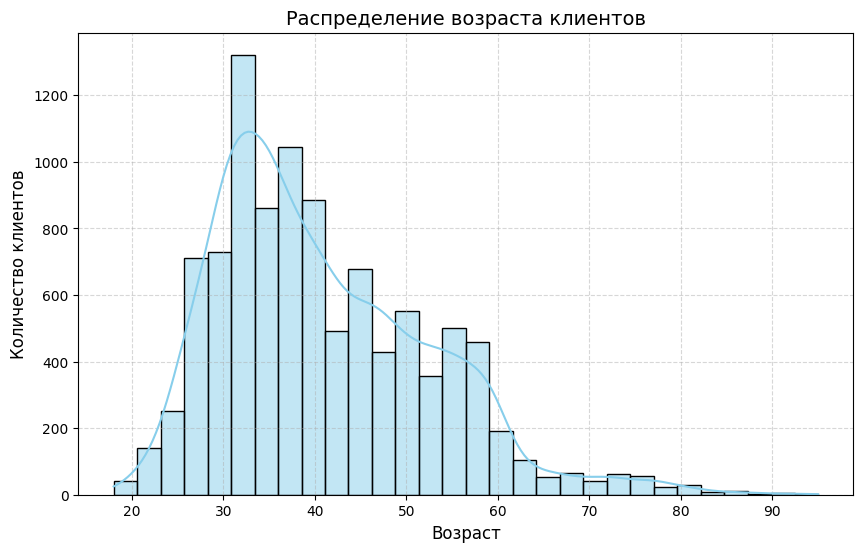

In [28]:
# распределение возраста (age)
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['age'], bins=30, kde=True, color='skyblue')
plt.title('Распределение возраста клиентов', fontsize=14)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

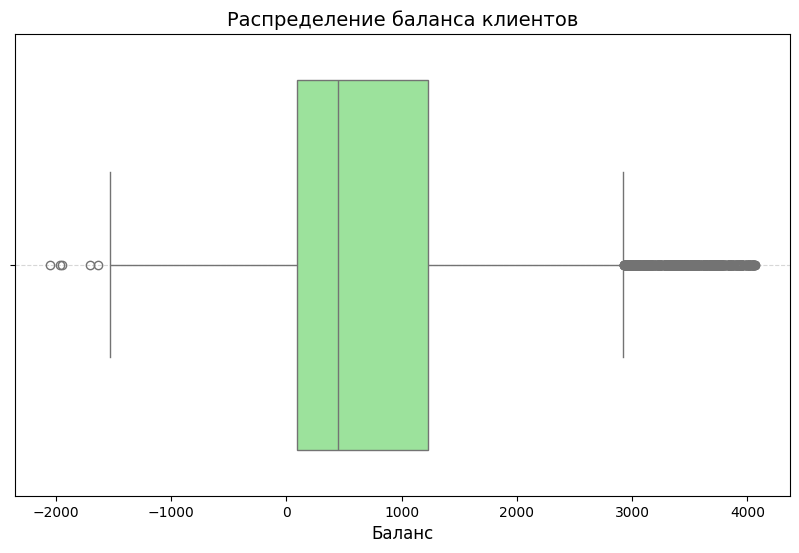

In [29]:
# ящик с усами для balance
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_filtered['balance'], color='lightgreen')
plt.title('Распределение баланса клиентов', fontsize=14)
plt.xlabel('Баланс', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

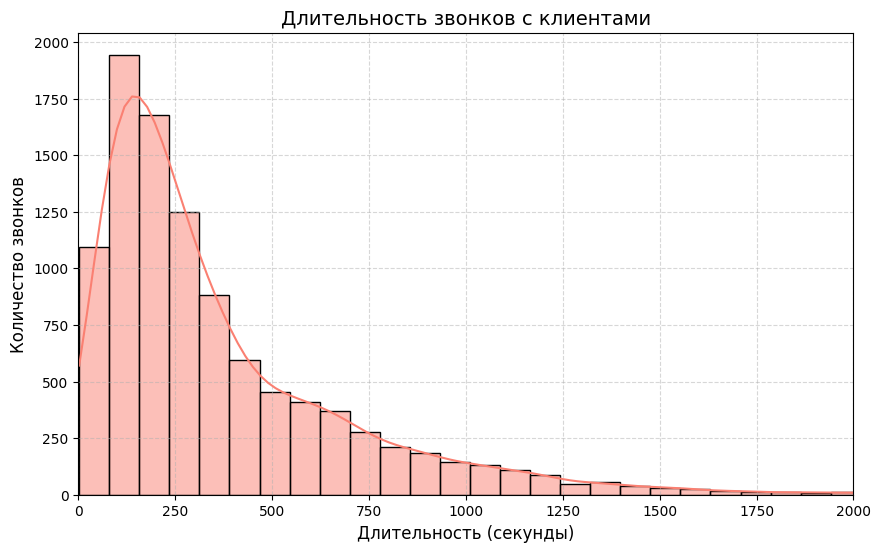

In [30]:
# распределение duration
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['duration'], bins=50, kde=True, color='salmon')
plt.title('Длительность звонков с клиентами', fontsize=14)
plt.xlabel('Длительность (секунды)', fontsize=12)
plt.ylabel('Количество звонков', fontsize=12)
plt.xlim(0, 2000)  # Исключаем крайние выбросы для наглядности
plt.grid(linestyle='--', alpha=0.5)
plt.show()

### Задания 4 и 5

In [31]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
# сфера занятности (job)
job_counts = df_filtered['job'].value_counts()
print(job_counts)

job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64


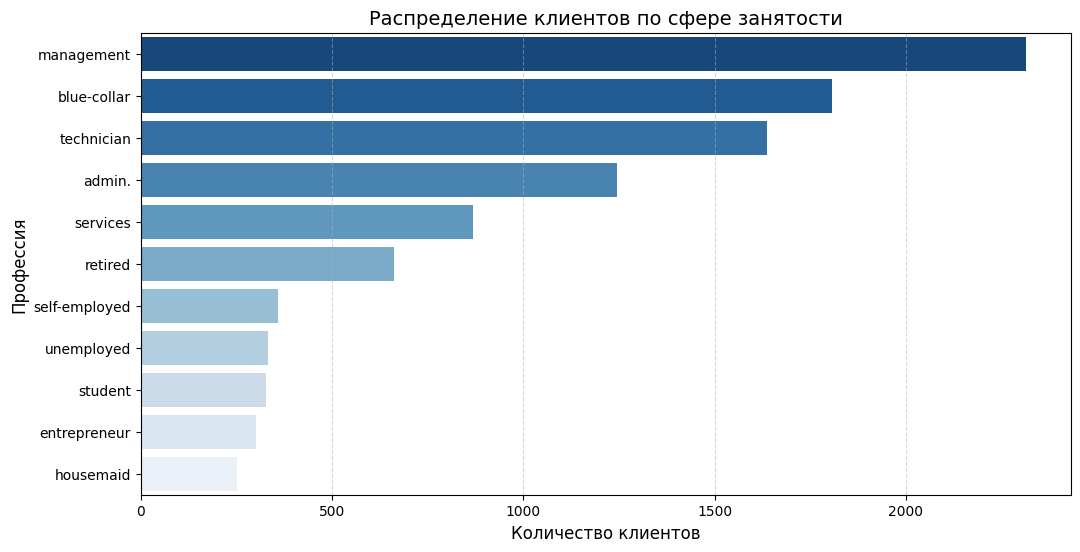

In [32]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_filtered, y='job', order=job_counts.index, palette='Blues_r')
plt.title('Распределение клиентов по сфере занятости', fontsize=14)
plt.xlabel('Количество клиентов', fontsize=12)
plt.ylabel('Профессия', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

Всего 11 сфер занятости.

Топ-3 профессии:
- Management (2315) — руководители.
- Blue-collar (1807) — рабочие.
- Technician (1638) — технические специалисты.

Редкие категории:
- Housemaid (252) — домработницы.

In [33]:
# Месяцы маркетинговой кампании (month)
# Задаем правильный порядок месяцев
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Считаем количество контактов по месяцам и сортируем согласно month_order
month_counts = df_filtered['month'].value_counts().reindex(month_order)
print(month_counts)

month
jan     319
feb     709
mar     237
apr     830
may    2617
jun    1104
jul    1418
aug    1385
sep     278
oct     335
nov     780
dec      93
Name: count, dtype: int64


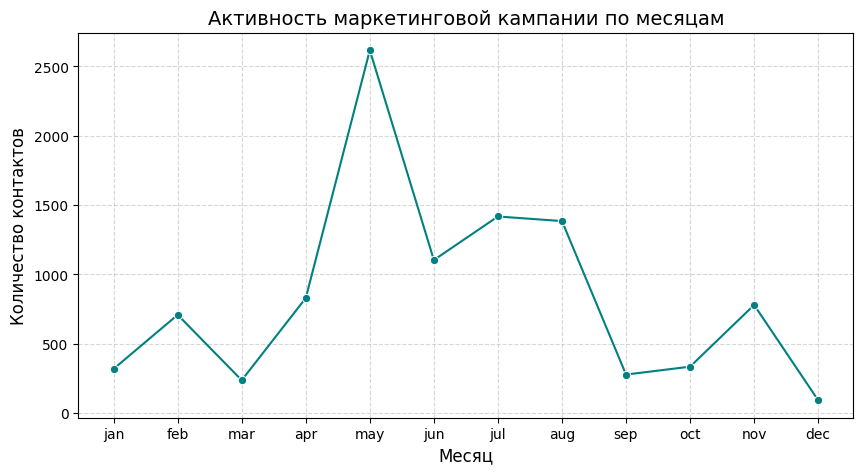

In [34]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=month_counts.index, y=month_counts.values, marker='o', color='teal')
plt.title('Активность маркетинговой кампании по месяцам', fontsize=14)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество контактов', fontsize=12)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

Кампания проводилась не во все месяцы:

- Пики активности: май (may — 2617 контактов).

- Провалы: декабрь (dec — 93).

Возможные причины:

- Сезонность (летом и зимой активность ниже).

- Ошибки в данных (например, пропущенные месяцы).

In [35]:
# Семейное положение (marital)
marital_counts = df_filtered['marital'].value_counts(normalize=True) * 100
print(marital_counts.round(1))

marital
married     56.6
single      31.8
divorced    11.6
Name: proportion, dtype: float64


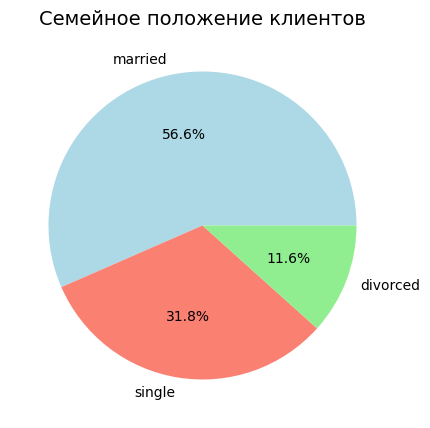

In [36]:
plt.figure(figsize=(8, 5))
marital_counts.plot(kind='pie', autopct='%.1f%%', colors=['lightblue', 'salmon', 'lightgreen'])
plt.title('Семейное положение клиентов', fontsize=14)
plt.ylabel('')
plt.show()

**Семейное положение клиентов банка**

Основная группа (чаще всего): 
- Married (56.6%) — семейные клиенты.
- Single (31,8%) - не замужем / не женат.

Реже всего: Divorced (11.2%) — разведенные.

In [37]:
# Образование (education)
education_counts = df_filtered['education'].value_counts(normalize=True) * 100
print(education_counts.round(1))

education
secondary    54.6
tertiary     32.1
primary      13.3
Name: proportion, dtype: float64


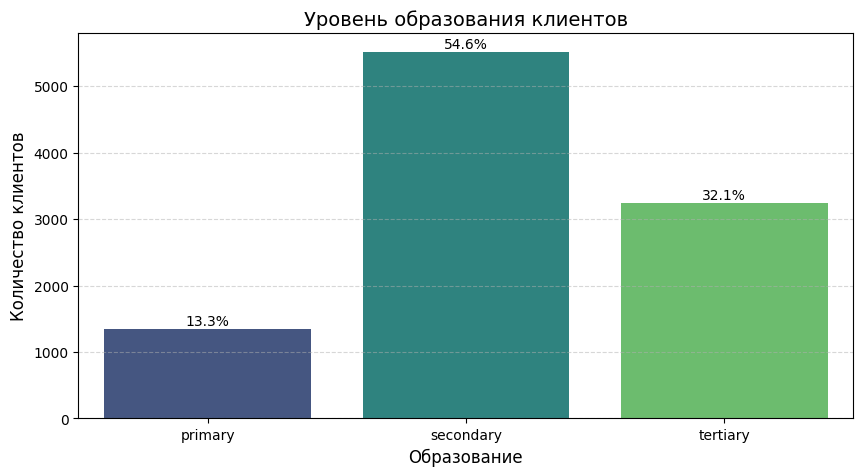

In [38]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_filtered, x='education', order=['primary', 'secondary', 'tertiary'], palette='viridis')
plt.title('Уровень образования клиентов', fontsize=14)
plt.xlabel('Образование', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Добавление процентов на столбцы
total = len(df_filtered)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2, height + 50, 
                   f'{height/total*100:.1f}%', ha='center')

plt.show()

Среди клиентов банка преобладают клиенты со средним образованием (54,6%).

### Задание 6

In [39]:
df_filtered['poutcome'].value_counts()


poutcome
unknown    7570
failure    1109
success     945
other       481
Name: count, dtype: int64

In [40]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# Создадим сводную таблицу
cross_tab = pd.crosstab(
    index=df_filtered['poutcome'],  # Результат предыдущей кампании
    columns=df_filtered['deposit'], # Текущий результат (депозит)
    margins=True,
    margins_name="Всего"
)

# Добавляем процент успеха по каждой категории
cross_tab['Успех (%)'] = (cross_tab['yes'] / cross_tab['Всего'] * 100).round(1)
print(cross_tab)

deposit     no   yes  Всего  Успех (%)
poutcome                              
failure    562   547   1109       49.3
other      216   265    481       55.1
success     84   861    945       91.1
unknown   4562  3008   7570       39.7
Всего     5424  4681  10105       46.3


In [41]:
# Создаем новый столбец 'deposit_num' с числовыми значениями
df_filtered['deposit_num'] = df_filtered['deposit'].map({'yes': 1, 'no': 0})

# Проверяем результат
print(df_filtered[['deposit', 'deposit_num']].value_counts())

deposit  deposit_num
no       0              5424
yes      1              4681
Name: count, dtype: int64


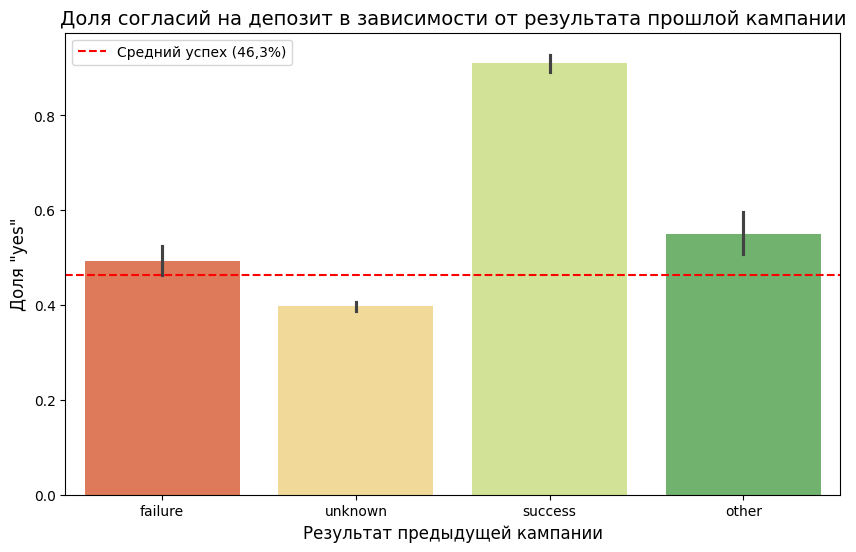

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_filtered, 
    x='poutcome', 
    y='deposit_num',  # Предварительно конвертируйте 'yes'/'no' в 1/0
    estimator='mean',
    order=['failure', 'unknown', 'success', 'other'],
    palette='RdYlGn'
)
plt.title('Доля согласий на депозит в зависимости от результата прошлой кампании', fontsize=14)
plt.xlabel('Результат предыдущей кампании', fontsize=12)
plt.ylabel('Доля "yes"', fontsize=12)
plt.axhline(y=0.463, color='red', linestyle='--', label='Средний успех (46,3%)')
plt.legend()
plt.show()

Для success (успех в прошлой кампании):

- 91,1% клиентов снова согласились на депозит. 
Это значительно выше общего среднего (46.3%).

Для failure (неудача в прошлой кампании):
- Только 49,3% согласились сейчас. Это неплохой показатель.

Для unknown (не было контакта или данные утеряны):
- Успех на уровне 39.7% (близко к среднему).

Клиенты, уже соглашавшиеся на предложение ранее, делают это снова. Это указывает на важность повторного взаимодействия с аудиторией.

### Задание 7

In [43]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# Создаем сводную таблицу по месяцам, чтобы определить месяц с самым высоким процентом отказов (deposit = 'no') в текущей кампании
# Считаем распределение 'no' и 'yes' по месяцам
monthly_deposit = pd.crosstab(
    index=df_filtered['month'],
    columns=df_filtered['deposit'],
    margins=False
)

# Добавляем столбец с % отказов
monthly_deposit['failure_rate'] = (monthly_deposit['no'] / (monthly_deposit['no'] + monthly_deposit['yes'])) * 100
monthly_deposit = monthly_deposit.sort_values('failure_rate', ascending=False)
print(monthly_deposit.round(1))

deposit    no  yes  failure_rate
month                           
may      1776  841          67.9
jan       194  125          60.8
jul       836  582          59.0
nov       456  324          58.5
aug       775  610          56.0
jun       606  498          54.9
feb       323  386          45.6
apr       317  513          38.2
oct        62  273          18.5
sep        46  232          16.5
mar        24  213          10.1
dec         9   84           9.7


In [44]:
worst_month = monthly_deposit['failure_rate'].idxmax()
print(f"Месяц c самым высоким % отказов по открытию депозитов: {worst_month}")

Месяц c самым высоким % отказов по открытию депозитов: may


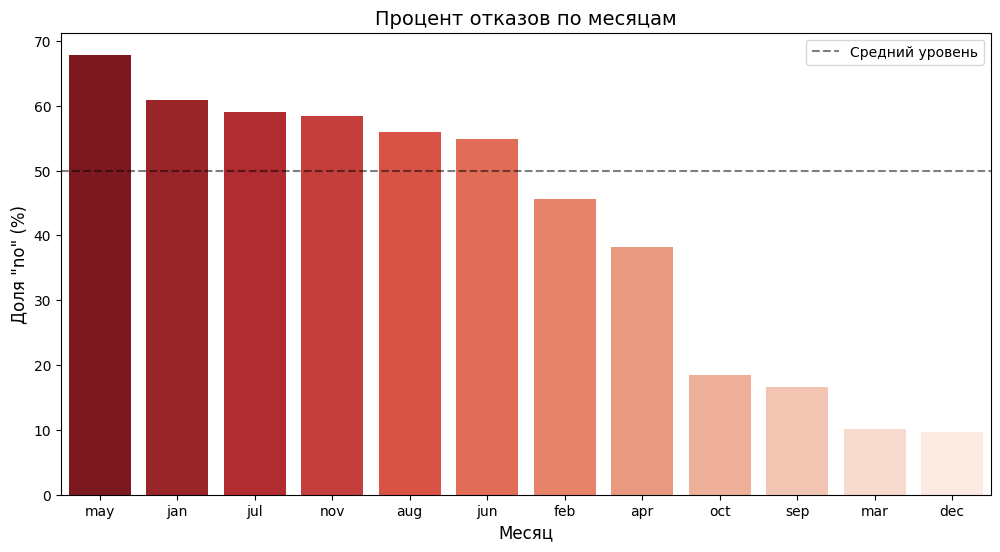

In [45]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=monthly_deposit.index,
    y=monthly_deposit['failure_rate'],
    order=monthly_deposit.index,  # Сортировка по убыванию
    palette='Reds_r'
)
plt.title('Процент отказов по месяцам', fontsize=14)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Доля "no" (%)', fontsize=12)
plt.axhline(y=50, color='black', linestyle='--', alpha=0.5, label='Средний уровень')
plt.legend()
plt.show()

**МАЙ** - месяц с самым высоким процентом отказов по открытию депозитов

### Задание 8

In [46]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# Анализ склонности к открытию депозита по возрастным группам
# Разделение на возрастные группы
bins = [0, 30, 40, 50, 60, 120]  # Границы интервалов
labels = ['<30', '30-40', '40-50', '50-60', '60+']  # Названия категорий
df_filtered['age_group'] = pd.cut(df_filtered['age'], bins=bins, labels=labels, right=False)

# Проверяем распределение
print(df_filtered['age_group'].value_counts().sort_index())

age_group
<30      1455
30-40    3961
40-50    2382
50-60    1654
60+       653
Name: count, dtype: int64


In [47]:
# Посчитаем долю открытий депозита по группам
# Сводная теблица по возрастным группам
age_deposit = pd.crosstab(
    index=df_filtered['age_group'], 
    columns=df_filtered['deposit'], 
    normalize='index'  # Нормализуем по строкам (доли)
).round(3) * 100

print(age_deposit)

deposit      no   yes
age_group            
<30        40.8  59.2
30-40      56.7  43.3
40-50      60.6  39.4
50-60      59.5  40.5
60+        24.0  76.0


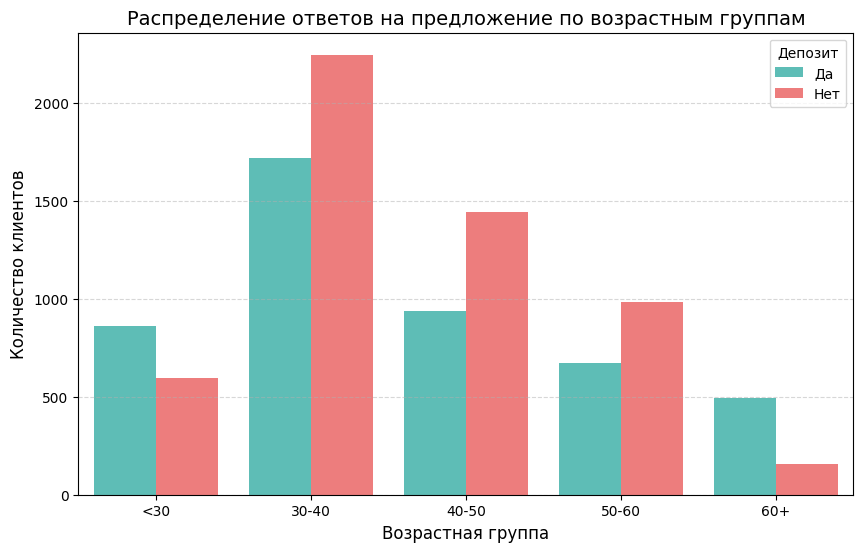

In [48]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_filtered, 
    x='age_group', 
    hue='deposit',
    order=labels,
    palette={'no': '#FF6B6B', 'yes': '#4ECDC4'}
)
plt.title('Распределение ответов на предложение по возрастным группам', fontsize=14)
plt.xlabel('Возрастная группа', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.legend(title='Депозит', labels=['Да', 'Нет'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

Самые склонные к открытию депозита группы (доля от группы):
- больше 60 лет (76%)
- меньше 30 лет (59,2%)

При этом по количеству клиентов больше всего депозитов открывают в возрасте 30-40 лет (1716 клиентов). 

### Задания 9 и 10

deposit       no     yes
marital                 
divorced  53.016  46.984
married   57.795  42.205
single    46.592  53.408
Средний процент согласий (yes): 47.5%


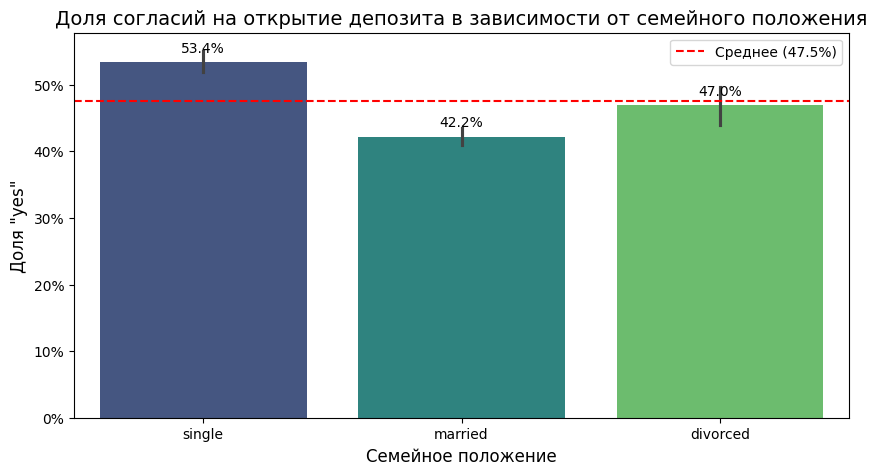

In [49]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
marital_deposit = pd.crosstab(
    index=df_filtered['marital'],
    columns=df_filtered['deposit'],
    normalize='index'
).round(5)

# Среднее по столбцу 'yes'
mean_yes = marital_deposit['yes'].mean().round(3)

print(marital_deposit*100)
print((f"Средний процент согласий (yes): {mean_yes*100}%"))

# Столбчатая диаграмма с процентами
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_filtered,
    x='marital',
    y='deposit_num',  # Числовой столбец (1=yes, 0=no)
    estimator='mean',
    order=['single', 'married', 'divorced'],
    palette='viridis'
)

# Преобразуем ось Y в проценты
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # 1.0 = 100%

plt.title('Доля согласий на открытие депозита в зависимости от семейного положения', fontsize=14)
plt.xlabel('Семейное положение', fontsize=12)
plt.ylabel('Доля "yes"', fontsize=12)
plt.axhline(y=mean_yes, color='red', linestyle='--', label=f'Среднее ({mean_yes*100:.1f}%)')
plt.legend()

# Добавляем подписи значений над столбцами
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.show()

Склонны к депозиту холостые (single = 53.4%) и разведенные (47.0%) 

deposit      no   yes
education            
primary    61.7  38.3
secondary  55.6  44.4
tertiary   47.1  52.9


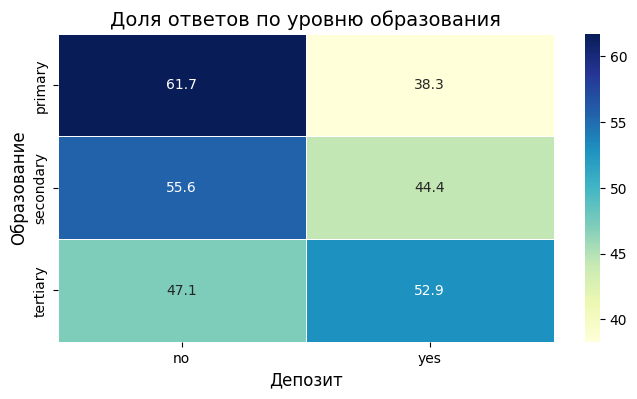

In [50]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
education_deposit = pd.crosstab(
    index=df_filtered['education'],
    columns=df_filtered['deposit'],
    normalize='index'
).round(3) * 100

print(education_deposit)

# Тепловая карта
plt.figure(figsize=(8, 4))
sns.heatmap(
    education_deposit,
    annot=True,
    fmt='.1f',
    cmap='YlGnBu',
    linewidths=0.5
)
plt.title('Доля ответов по уровню образования', fontsize=14)
plt.xlabel('Депозит', fontsize=12)
plt.ylabel('Образование', fontsize=12)
plt.show()

Склонны к депозиту: Клиенты с высшим образованием (tertiary, 52.9%).

Реже соглашаются: С начальным образованием (primary, 38.3%).

deposit          no   yes
job                      
admin.         53.9  46.1
blue-collar    63.9  36.1
entrepreneur   63.0  37.0
housemaid      60.7  39.3
management     51.0  49.0
retired        34.8  65.2
self-employed  55.0  45.0
services       60.3  39.7
student        24.8  75.2
technician     54.9  45.1
unemployed     43.1  56.9
Средний процент согласий (yes): 48.6%


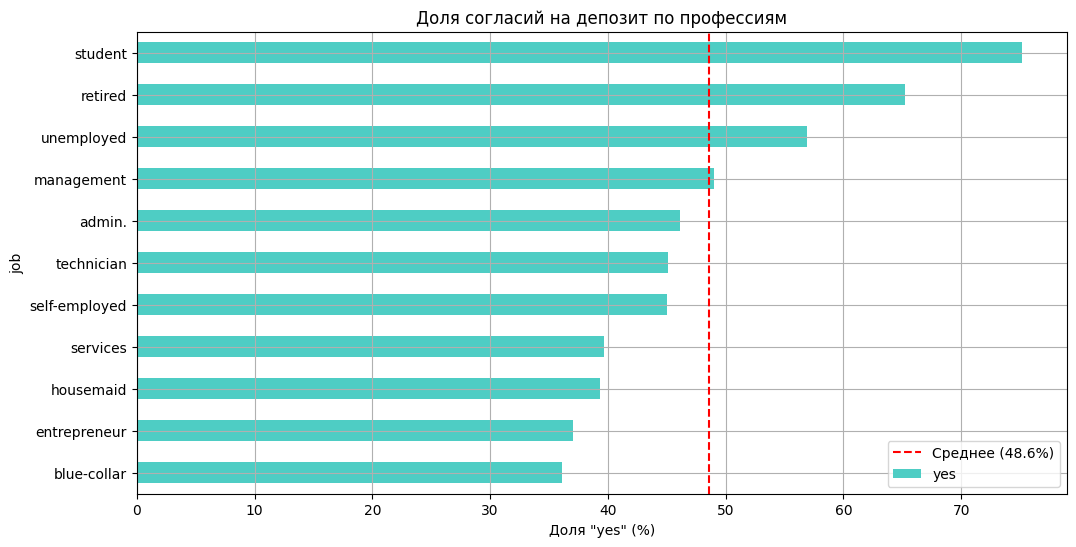

In [51]:
# визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
job_deposit = pd.crosstab(
    index=df_filtered['job'],
    columns=df_filtered['deposit'],
    normalize='index'
).round(3) * 100

mean_yes_job_deposit = job_deposit['yes'].mean().round(1)

print(job_deposit)
print(f'Средний процент согласий (yes): {mean_yes_job_deposit}%')

# Горизонтальная столбчатая диаграмма
job_deposit['yes'].sort_values().plot(
    kind='barh',
    figsize=(12, 6),
    color='#4ECDC4',
    title='Доля согласий на депозит по профессиям',
    xlabel='Доля "yes" (%)',
    grid=True
)
plt.axvline(x=mean_yes_job_deposit, color='red', linestyle='--', label=f'Среднее ({mean_yes_job_deposit}%)')
plt.legend()
plt.show()

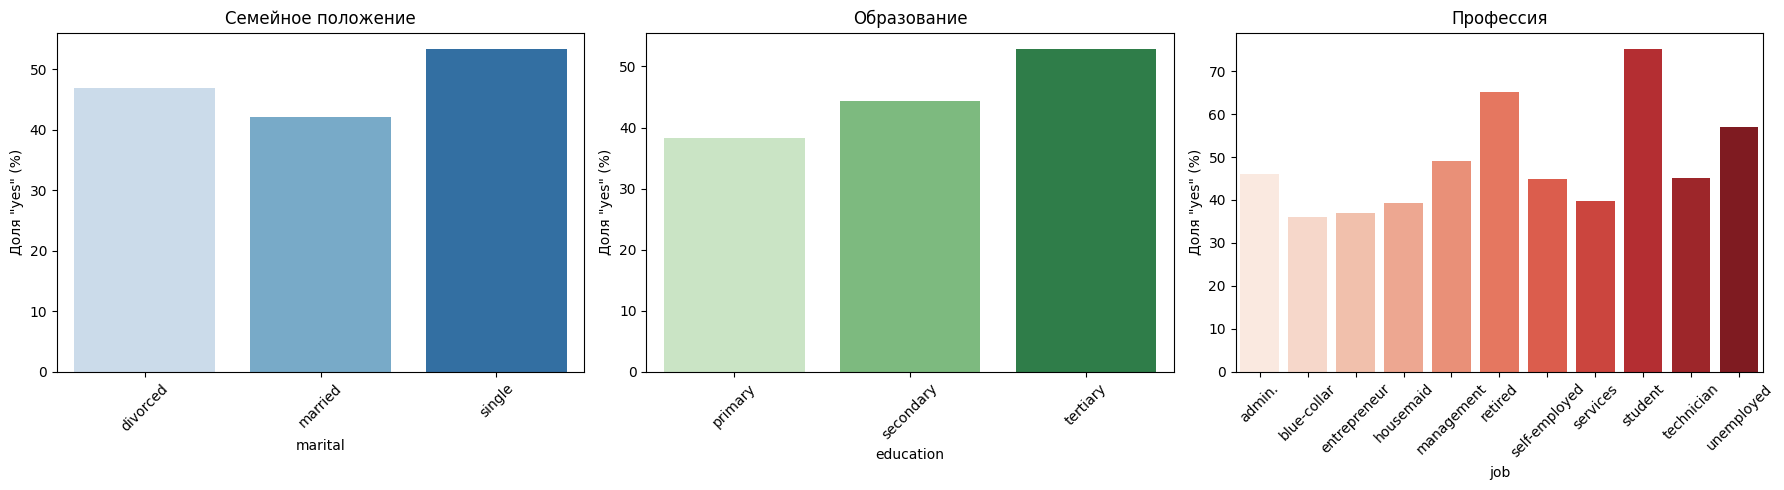

In [52]:
# построим объединенный график
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(x=marital_deposit.index, y=marital_deposit['yes']*100, ax=axes[0], palette='Blues')
sns.barplot(x=education_deposit.index, y=education_deposit['yes'], ax=axes[1], palette='Greens')
sns.barplot(x=job_deposit.index, y=job_deposit['yes'], ax=axes[2], palette='Reds')
axes[0].set_title('Семейное положение')
axes[1].set_title('Образование')
axes[2].set_title('Профессия')
for ax in axes:
    ax.set_ylabel('Доля "yes" (%)')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64


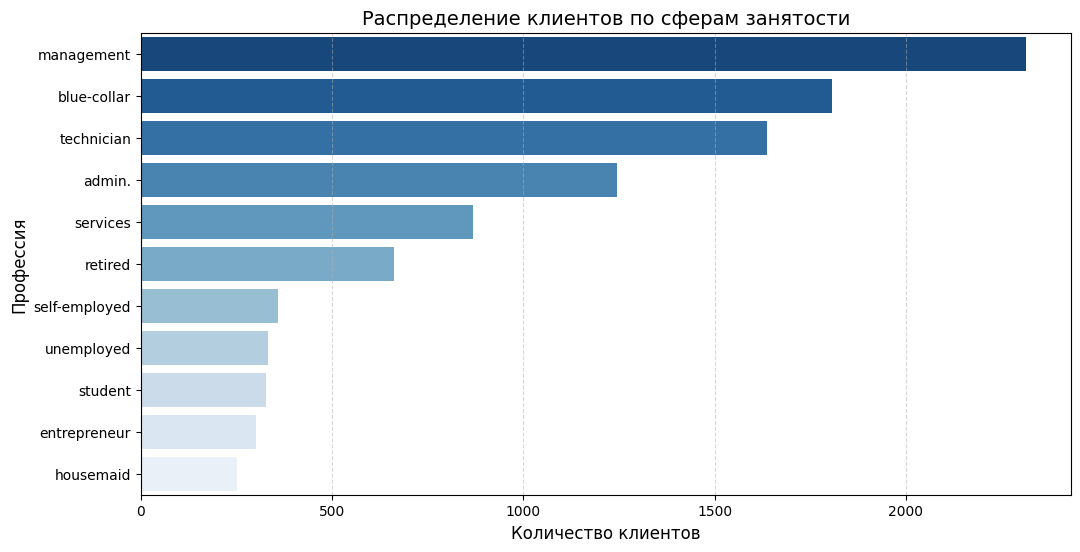

In [53]:
# В какой сфере занято наибольшее число клиентов банка? (см. задания 4-5)
job_counts = df_filtered['job'].value_counts()
print(job_counts)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=job_counts.values,
    y=job_counts.index,
    palette='Blues_r'
)
plt.title('Распределение клиентов по сферам занятости', fontsize=14)
plt.xlabel('Количество клиентов', fontsize=12)
plt.ylabel('Профессия', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

**В какой сфере занято наибольшее число клиентов банка?**

Ответ: management (2315 клиентов)

### Задание 11

In [54]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# Для открывших депозит (deposit = 'yes')
df_yes = df_filtered[df_filtered['deposit'] == 'yes']

# Для не открывших депозит (deposit = 'no')
df_no = df_filtered[df_filtered['deposit'] == 'no']

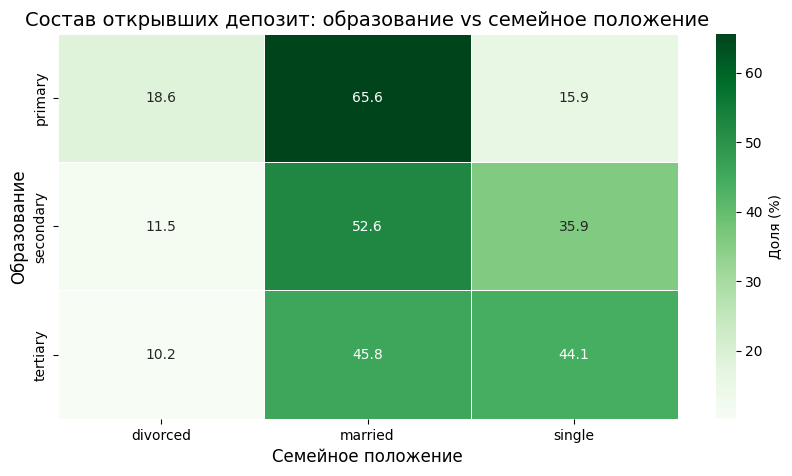

In [55]:
# Сводная таблица и тепловая карта для открывших депозит (deposit = 'yes')
pivot_yes = pd.crosstab(
    index=df_yes['education'],
    columns=df_yes['marital'],
    normalize='index'  # Нормируем по строкам (уровням образования)
).round(3) * 100

plt.figure(figsize=(10, 5))
sns.heatmap(
    pivot_yes,
    annot=True,
    fmt='.1f',
    cmap='Greens',
    linewidths=0.5,
    cbar_kws={'label': 'Доля (%)'}
)
plt.title('Состав открывших депозит: образование vs семейное положение', fontsize=14)
plt.xlabel('Семейное положение', fontsize=12)
plt.ylabel('Образование', fontsize=12)
plt.show()

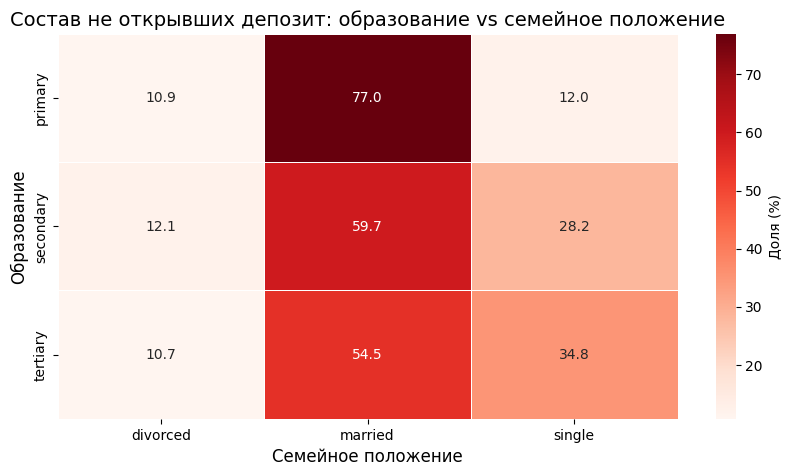

In [56]:
# Сводная таблица и тепловая карта для не открывших депозит (deposit = 'no')
pivot_no = pd.crosstab(
    index=df_no['education'],
    columns=df_no['marital'],
    normalize='index'
).round(3) * 100

plt.figure(figsize=(10, 5))
sns.heatmap(
    pivot_no,
    annot=True,
    fmt='.1f',
    cmap='Reds',
    linewidths=0.5,
    cbar_kws={'label': 'Доля (%)'}
)
plt.title('Состав не открывших депозит: образование vs семейное положение', fontsize=14)
plt.xlabel('Семейное положение', fontsize=12)
plt.ylabel('Образование', fontsize=12)
plt.show()

## **Выводы**

**Среди открывших депозит преобладают:**

Женатые клиенты с начальным образованием (primary + married). Их доля в группе с начальным образованием — 65.6% (максимальное значение в тепловой карте yes).

**Среди не открывших депозит лидируют:**

Женатые клиенты с начальным образованием (primary + married). Их доля — 77% в своей группе.

**Рекомендации:**

Для женатых клиентов с начальным образованием рекомендуются упрощенные депозиты с гарантированной доходностью и минимальным риском.

В целом, образование и семейное положение значимо влияют на решение о депозите. Маркетинг должен быть адресным для разных групп.

## Часть 3: преобразование данных

### Задание 1

In [57]:
# преобразуйте уровни образования
# используем LabelEncoder для кодирования категориального признака education в числа:
#from sklearn.preprocessing import LabelEncoder

# Создаем копию признака, чтобы не изменять исходные данные
df_filtered['education_encoded'] = df_filtered['education'].copy()

# Инициализируем и применяем LabelEncoder
le = LabelEncoder()
df_filtered['education_encoded'] = le.fit_transform(df_filtered['education'])

# Проверяем соответствие категорий и чисел
print("Соответствие категорий и кодов:")
for category, code in zip(le.classes_, range(len(le.classes_))):
    print(f"{category}: {code}")

Соответствие категорий и кодов:
primary: 0
secondary: 1
tertiary: 2


In [58]:
# Расчет суммы закодированных значений
sum_education_encoded = df_filtered['education_encoded'].sum()
print(f"Сумма закодированных значений: {sum_education_encoded}")

Сумма закодированных значений: 11995


In [59]:
# Важно: Если в данных есть пропуски (NaN), LabelEncoder вызовет ошибку. В этом случае сначала нужно заменить их на строку 'unknown':
#df_filtered['education'] = df_filtered['education'].fillna('unknown')

In [60]:
# проверка распределения
print("Распределение закодированных значений:")
print(df_filtered['education_encoded'].value_counts().sort_index())

Распределение закодированных значений:
education_encoded
0    1349
1    5517
2    3239
Name: count, dtype: int64


### Задание 2

In [61]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# Преобразование возрастных групп (age_group) в числовой формат

# Задаем правильный порядок категорий
correct_order = ['<30', '30-40', '40-50', '50-60', '60+']

# Создаем и обучаем LabelEncoder с нашим порядком
le = LabelEncoder()
le.fit(correct_order)  # Явно задаем порядок кодирования

# Применяем к данным
df_filtered['age_group_encoded'] = le.transform(df_filtered['age_group'])

# Проверяем результат
print("Кодировка age_group:")
for category, code in zip(le.classes_, range(len(le.classes_))):
    print(f"{category}: {code}")

Кодировка age_group:
30-40: 0
40-50: 1
50-60: 2
60+: 3
<30: 4


In [62]:
# Преобразование целевой переменной deposit в бинарный вид
# Заменим yes на 1, no на 0:
df_filtered['deposit_encoded'] = df_filtered['deposit'].map({'yes': 1, 'no': 0})

# Альтернативный вариант:
# df_filtered['deposit_encoded'] = np.where(df_filtered['deposit'] == 'yes', 1, 0)

print("Распределение deposit_encoded:")
print(df_filtered['deposit_encoded'].value_counts())

Распределение deposit_encoded:
deposit_encoded
0    5424
1    4681
Name: count, dtype: int64


Для бинарной переменной стандартное отклонение вычисляется по формуле:

σ = $ \sqrt{p*(1−p)} $, где 
p = число единиц / общее количество



In [63]:
# Расчет стандартного отклонения для deposit_encoded
std_deposit = df_filtered['deposit_encoded'].std().round(3)
print(f"Стандартное отклонение deposit_encoded: {std_deposit}")

Стандартное отклонение deposit_encoded: 0.499


In [64]:
# проверка
p = df_filtered['deposit_encoded'].mean()  # Доля единиц
std_manual = np.sqrt(p * (1 - p)).round(3)
std_manual

np.float64(0.499)

### Задание 3

In [65]:
# Преобразование бинарных переменных
# Заменим 'yes' на 1 и 'no' на 0 для всех указанных бинарных признаков (через map):
binary_vars = ['default', 'housing', 'loan']

for var in binary_vars:
    df_filtered[f'{var}_encoded'] = df_filtered[var].map({'yes': 1, 'no': 0})

# Проверка преобразования
print(df_filtered[binary_vars + [f'{var}_encoded' for var in binary_vars]].head())

# Вычислим среднее для каждой преобразованной переменной:
means = {}
for var in binary_vars:
    means[var] = df_filtered[f'{var}_encoded'].mean().round(3)

print("Средние значения:")
for var, mean in means.items():
    print(f"{var}: {mean}")

# Суммирование результатов
total_sum = sum(means.values())
print(f"Сумма средних: {total_sum:.3f}")

  default housing loan  default_encoded  housing_encoded  loan_encoded
0      no     yes   no                0                1             0
1      no      no   no                0                0             0
2      no     yes   no                0                1             0
3      no     yes   no                0                1             0
4      no      no   no                0                0             0
Средние значения:
default: 0.016
housing: 0.481
loan: 0.138
Сумма средних: 0.635


In [66]:
# теперь сделаем то же самое через LabelEncoder():

# Инициализация LabelEncoder
le = LabelEncoder()

# Список бинарных переменных
binary_vars = ['default', 'housing', 'loan']

# Преобразование каждой переменной
for var in binary_vars:
    df_filtered[f'{var}_encoded'] = le.fit_transform(df_filtered[var])
    
    # Проверка соответствия кодировки
    print(f"Кодировка для {var}:")
    for category, code in zip(le.classes_, range(len(le.classes_))):
        print(f"  {category}: {code}")

# Вычисление средних значений
means = [df_filtered[f'{var}_encoded'].mean().round(3) for var in binary_vars]
total_sum = sum(means).round(3)

print("\nСредние значения закодированных переменных:")
for var, mean in zip(binary_vars, means):
    print(f"{var}: {mean}")

print(f"\nСумма средних: {total_sum}")

Кодировка для default:
  no: 0
  yes: 1
Кодировка для housing:
  no: 0
  yes: 1
Кодировка для loan:
  no: 0
  yes: 1

Средние значения закодированных переменных:
default: 0.016
housing: 0.481
loan: 0.138

Сумма средних: 0.635


Интерпретация средних:
- default = 0.016 → Только 1.6% клиентов имеют дефолт (очень мало).
- housing = 0.481 → 48.1% имеют жилищный кредит.
- loan = 0.138 → 13.8% имеют персональный кредит.

Проверка корректности:
Сумма средних должна быть в диапазоне [0, 3], так как каждое среднее ∈ [0, 1]. Полученное значение 0.635 — допустимо.

### Задание 4

In [67]:
# создайте дамми-переменные
# Список номинальных переменных для преобразования
nominal_vars = ['job', 'marital', 'contact', 'month', 'poutcome']

# Создание dummy-переменных (без удаления исходных колонок)
df_nominal = pd.get_dummies(df_filtered, columns=nominal_vars, drop_first=False)

# Проверка первых 3 строк для примера
print(df_nominal.filter(like='_', axis=1).head(3))

   deposit_num age_group  education_encoded  age_group_encoded  \
0            1     50-60                  1                  2   
1            1     50-60                  1                  2   
2            1     40-50                  1                  1   

   deposit_encoded  default_encoded  housing_encoded  loan_encoded  \
0                1                0                1             0   
1                1                0                0             0   
2                1                0                1             0   

   job_admin.  job_blue-collar  ...  month_jun  month_mar  month_may  \
0        True            False  ...      False      False       True   
1        True            False  ...      False      False       True   
2       False            False  ...      False      False       True   

   month_nov  month_oct  month_sep  poutcome_failure  poutcome_other  \
0      False      False      False             False           False   
1      False      Fal

In [68]:
df_nominal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10105 entries, 0 to 10104
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                10105 non-null  int64   
 1   education          10105 non-null  object  
 2   default            10105 non-null  object  
 3   balance            10105 non-null  float64 
 4   housing            10105 non-null  object  
 5   loan               10105 non-null  object  
 6   day                10105 non-null  int64   
 7   duration           10105 non-null  int64   
 8   campaign           10105 non-null  int64   
 9   pdays              10105 non-null  int64   
 10  previous           10105 non-null  int64   
 11  deposit            10105 non-null  object  
 12  deposit_num        10105 non-null  int64   
 13  age_group          10105 non-null  category
 14  education_encoded  10105 non-null  int64   
 15  age_group_encoded  10105 non-null  int64   
 16  depo

In [69]:
# подсчет общего числа признаков
# Исходные числовые признаки (без учета целевой 'deposit_encoded')
numeric_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 
                   'age_group_encoded', 'default_encoded', 'housing_encoded', 'loan_encoded']

# Dummy-переменные (новые колонки)
dummy_features = [col for col in df_nominal.columns if '_' in col and col not in numeric_features]

# Общее число признаков (исходные числовые + dummy)
total_features = len(numeric_features) + len(dummy_features) + len(binary_vars)

print(f"Число исходных числовых признаков: {len(numeric_features)}")
print(f"Число исходных бинарных признаков: {len(binary_vars)}")
print(f"Число dummy-переменных: {len(dummy_features)}")
print(f"Общее число признаков: {total_features}")

Число исходных числовых признаков: 10
Число исходных бинарных признаков: 3
Число dummy-переменных: 37
Общее число признаков: 50


Таким образом, общее число признаков в датасете (без учета целевой переменной): 50

In [70]:
# Проверка (должно получиться 50)
# Убедимся, что исключили целевую переменную 'deposit' и связанную с ней другие признаки
# Получаем список всех признаков, содержащих "deposit" в названии
deposit_related_features = [col for col in df_nominal.columns if 'deposit' in col.lower()]

# Подсчитываем количество таких признаков
num_deposit_features = len(deposit_related_features)

# Выводим результаты
print("Список признаков, связанных с 'deposit':")
print(deposit_related_features)
print(f"\nОбщее количество таких признаков: {num_deposit_features}")

print(f"Точное число признаков: {len(df_nominal.columns)} - {num_deposit_features} = {len(df_nominal.columns) - num_deposit_features}")

Список признаков, связанных с 'deposit':
['deposit', 'deposit_num', 'deposit_encoded']

Общее количество таких признаков: 3
Точное число признаков: 53 - 3 = 50


### Задания 5 и 6

In [71]:
# удалим из df_nominal столбец 'deposit_num', идентичный столбцу 'deposit_encoded'
df_nominal = df_nominal.drop(columns=['deposit_num'])

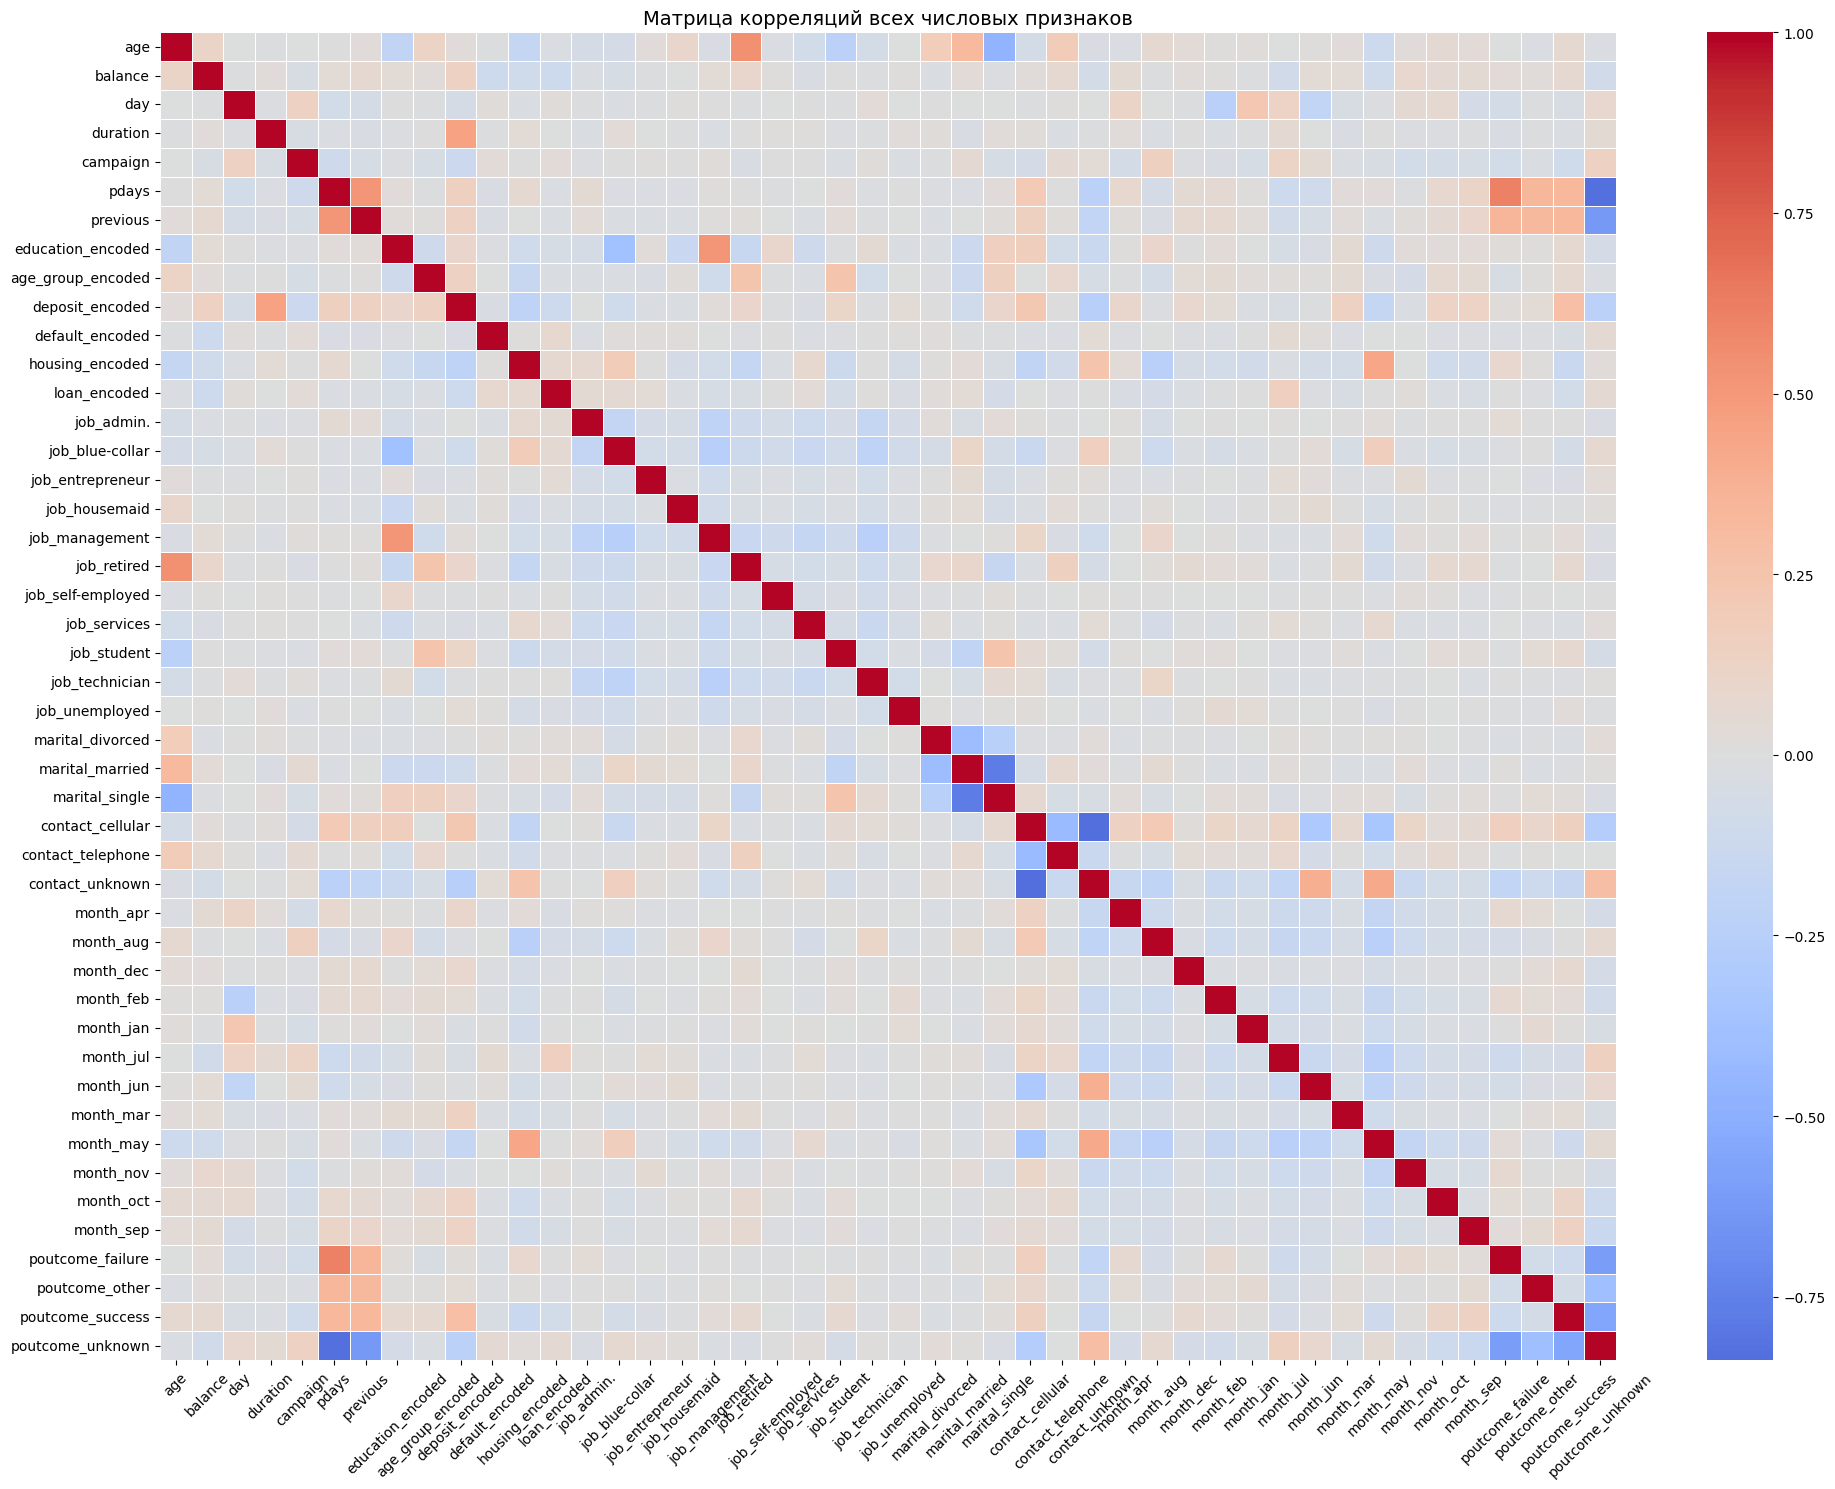

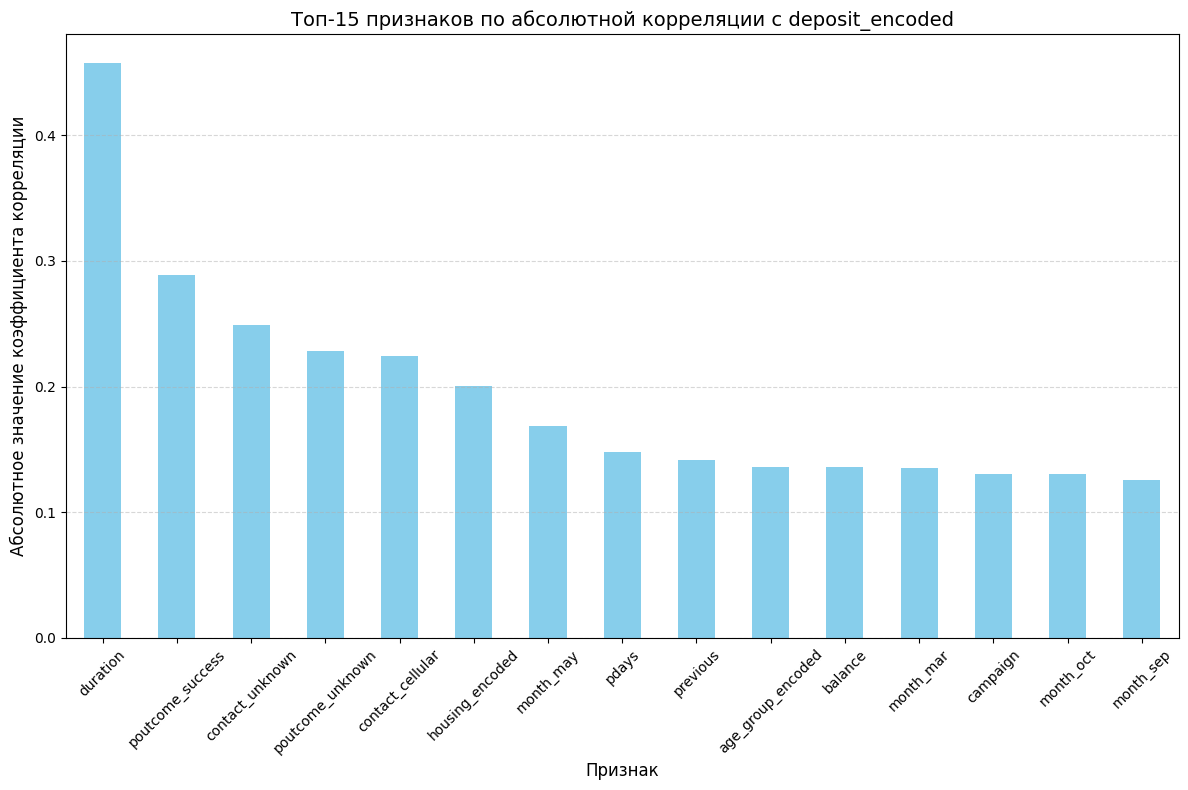

Корреляции с целевой переменной:
                   correlation
duration              0.457818
poutcome_success      0.288491
contact_cellular      0.223944
pdays                 0.147917
previous              0.141102
age_group_encoded     0.136243
balance               0.135893
month_mar             0.135348
month_oct             0.130599
month_sep             0.125239
job_student           0.105563
job_retired           0.100090
education_encoded     0.098253
marital_single        0.097005
month_apr             0.092888
month_dec             0.085041
month_feb             0.044728
poutcome_other        0.039319
job_unemployed        0.039196
job_management        0.029566
age                   0.024357
poutcome_failure      0.021124
contact_telephone     0.007064
marital_divorced      0.004808
job_admin.           -0.001927
job_self-employed    -0.005194
month_jun            -0.008533
job_technician       -0.011190
month_aug            -0.018225
job_housemaid        -0.022572
month_

In [72]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

#Преобразуем целевую переменную в числовой формат (если еще не сделано, но у нас это было сделано ранее)
#df_nominal['deposit_encoded'] = df_nominal['deposit'].map({'yes': 1, 'no': 0})

# 1. Выбираем только числовые признаки (включая dummy-переменные), не забываем про булевые переменные
numeric_cols = df_nominal.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

# 2. Строим матрицу корреляций
corr_matrix = df_nominal[numeric_cols].corr()

# 3. Тепловая карта корреляций
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, 
            annot=False, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f',
            linewidths=0.5)
plt.title('Матрица корреляций всех числовых признаков', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Корреляции с целевой переменной
target_corr = corr_matrix['deposit_encoded'].drop('deposit_encoded').sort_values()

# 5. Столбчатая диаграмма топ-корреляций
plt.figure(figsize=(12, 8))
target_corr.abs().sort_values(ascending=False).head(15).plot(
    kind='bar',
    color=['skyblue' if x > 0 else 'salmon' for x in target_corr.abs().sort_values(ascending=False).head(15)]
)
plt.title('Топ-15 признаков по абсолютной корреляции с deposit_encoded', fontsize=14)
plt.xlabel('Признак', fontsize=12)
plt.ylabel('Абсолютное значение коэффициента корреляции', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Выводим таблицу корреляций с целевой переменной
print("Корреляции с целевой переменной:")
print(target_corr.sort_values(ascending=False).to_frame('correlation'))

### Задания 7 и 8

In [73]:
# разделим выборку на обучающую и тестовую.
# при разбиении задайте параметр random_state = 42, а размер тестовой выборки возьмите за 0,33. 
# не забудьте добавить аргумент, определяющий сохранение соотношений целевого признака.
X = df_nominal.drop(['deposit_encoded'], axis=1)
y = df_nominal['deposit_encoded']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

# Проверка размеров выборок
print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")

Размер обучающей выборки: 6770
Размер тестовой выборки: 3335


In [74]:
# рассчитайте необходимые показатели
mean_test = y_test.mean().round(2)
print(f"Среднее значение целевой переменной на тесте: {mean_test}")

train_balance = y_train.value_counts(normalize=True).round(2)
test_balance = y_test.value_counts(normalize=True).round(2)

print("\nБаланс классов:")
print(f"Обучающая выборка:\n{train_balance}")
print(f"Тестовая выборка:\n{test_balance}")

Среднее значение целевой переменной на тесте: 0.46

Баланс классов:
Обучающая выборка:
deposit_encoded
0    0.54
1    0.46
Name: proportion, dtype: float64
Тестовая выборка:
deposit_encoded
0    0.54
1    0.46
Name: proportion, dtype: float64


### Задание 9

In [75]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

#from sklearn.feature_selection import SelectKBest, f_classif
# Выбираем только числовые признаки (исключаем категориальные)
numeric_cols = X_train.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
X_train_numeric = X_train[numeric_cols]

# Инициализация селектора
selector = SelectKBest(score_func=f_classif, k=15) #ANOVA F-статистика для классификации, k=15 - количество отбираемых признаков.

# Обучение на train и преобразование выборок
X_train_selected = selector.fit_transform(X_train_numeric, y_train)
X_test_selected = selector.transform(X_test[numeric_cols])

# Получение имен выбранных признаков
selected_features = X_train_numeric.columns[selector.get_support()].tolist()

print("Топ-15 значимых признаков:")
for idx, feature in enumerate(selected_features, 1):
    print(f"{idx}. {feature}")

print(f"\nРазмер X_train до отбора: {X_train_numeric.shape}")
print(f"Размер X_train после отбора: {X_train_selected.shape}")

Топ-15 значимых признаков:
1. balance
2. duration
3. campaign
4. pdays
5. previous
6. age_group_encoded
7. housing_encoded
8. contact_cellular
9. contact_unknown
10. month_mar
11. month_may
12. month_oct
13. month_sep
14. poutcome_success
15. poutcome_unknown

Размер X_train до отбора: (6770, 45)
Размер X_train после отбора: (6770, 15)


In [76]:
# Дополнительная проверка - убедимся, что в выбранных признаках нет категориальных данных:
print("Типы выбранных признаков:")
print(X_train[selected_features].dtypes)

Типы выбранных признаков:
balance              float64
duration               int64
campaign               int64
pdays                  int64
previous               int64
age_group_encoded      int64
housing_encoded        int64
contact_cellular        bool
contact_unknown         bool
month_mar               bool
month_may               bool
month_oct               bool
month_sep               bool
poutcome_success        bool
poutcome_unknown        bool
dtype: object


In [77]:
# DataFrame с оценками значимости
feature_scores = pd.DataFrame({
    'Признак': X_train_numeric.columns,
    'F-статистика': selector.scores_,
    'p-value': selector.pvalues_
}).sort_values('F-статистика', ascending=False)

print("\nТоп-15 признаков по F-статистике:")
print(feature_scores.head(15).round(4))


Топ-15 признаков по F-статистике:
              Признак  F-статистика  p-value
3            duration     1839.0782      0.0
43   poutcome_success      628.3516      0.0
28    contact_unknown      427.5577      0.0
44   poutcome_unknown      373.0068      0.0
26   contact_cellular      350.5020      0.0
10    housing_encoded      301.2642      0.0
37          month_may      183.8760      0.0
6            previous      153.9238      0.0
5               pdays      148.7500      0.0
8   age_group_encoded      147.4814      0.0
4            campaign      139.4867      0.0
40          month_sep      130.2300      0.0
39          month_oct      125.3197      0.0
36          month_mar      114.7596      0.0
1             balance      114.3564      0.0


### Задание 10

In [78]:
# нормализуйте данные с помощью minmaxsxaler
# Используем MinMaxScaler для приведения признаков к диапазону [0, 1]:

from sklearn.preprocessing import MinMaxScaler

# Инициализация scaler (обучение ТОЛЬКО на train)
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_selected)  # Обучаем и преобразуем train
X_test_normalized = scaler.transform(X_test_selected)        # Только преобразуем test

# Преобразование обратно в DataFrame для наглядности
X_train_norm_df = pd.DataFrame(X_train_normalized, columns=selected_features)
X_test_norm_df = pd.DataFrame(X_test_normalized, columns=selected_features)

In [79]:
# рассчитаем среднее для первого предиктора в тестовой выборке
first_predictor_mean = X_test_norm_df.iloc[:, 0].mean().round(2)  # Первый столбец
print(f"Среднее значение первого предиктора в тестовой выборке: {first_predictor_mean}")

Среднее значение первого предиктора в тестовой выборке: 0.47


In [80]:
# проверка результатов
print("\nПроверка нормализации (тестовая выборка):")
print(f"Минимум: {X_test_norm_df.iloc[:, 0].min():.2f}")
print(f"Максимум: {X_test_norm_df.iloc[:, 0].max():.2f}")


Проверка нормализации (тестовая выборка):
Минимум: 0.02
Максимум: 1.00


In [81]:
# дополнительная проверка - убедимся, что целевая переменная y_test не была нормализована:
print("\nЦелевая переменная (первые 5 значений):")
print(y_test.head())


Целевая переменная (первые 5 значений):
2933    1
5397    0
5043    0
2295    1
8102    0
Name: deposit_encoded, dtype: int64


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Инициализация модели
logreg = LogisticRegression(
    solver='sag',       # Алгоритм оптимизации - Stochastic Average Gradient, подходит для больших датасетов.
    random_state=42,    # Фиксация случайности
    max_iter=1000       # Число итераций - гарантирует сходимость (по умолчанию 100 может быть недостаточно).
)

# Обучение на нормализованных train-данных
logreg.fit(X_train_normalized, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [96]:
# Предсказание для тестовых данных
y_pred = logreg.predict(X_test_normalized)

# Расчет accuracy
accuracy = round(accuracy_score(y_test, y_pred), 2)
print(f"Accuracy на тестовой выборке: {accuracy}")

Accuracy на тестовой выборке: 0.8


In [89]:
from sklearn.metrics import classification_report

print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred, target_names=['no', 'yes']))


Отчет по классификации:
              precision    recall  f1-score   support

          no       0.79      0.87      0.83      1790
         yes       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



Интерпретация accuracy:

- 0.80 означает, что модель правильно предсказала депозит для 80% клиентов.
- Сравните с балансом классов (у нас 54% yes, то accuracy > 0.54 — лучше случайного угадывания).

In [ ]:
# проверка переобучения
train_accuracy = round(accuracy_score(y_train, logreg.predict(X_train_normalized)), 2)
print(f"Accuracy на обучающей выборке: {train_accuracy}")

Accuracy на обучающей выборке: 0.82


Получаем, что train_accuracy (0.82) > test_accuracy (0.80). Есть подозрение на переобучение (особенно, если train_accuracy >> test_accuracy).

### Задания 2,3,4

In [92]:
# обучите решающие деревья, настройте максимальную глубину
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Инициализация модели
dtree = DecisionTreeClassifier(
    criterion='entropy',  # Критерий разделения
    random_state=42       # Фиксация случайности
)

# Обучение на нормализованных данных
dtree.fit(X_train_normalized, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [ ]:
# Предсказание
y_pred_dtree = dtree.predict(X_test_normalized)

# Accuracy
accuracy_dtree = round(accuracy_score(y_test, y_pred_dtree), 2)
print(f"Accuracy решающего дерева: {accuracy_dtree}")

# Отчет по классификации
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred_dtree, target_names=['no', 'yes']))

Accuracy решающего дерева: 0.75

Отчет по классификации:
              precision    recall  f1-score   support

          no       0.76      0.78      0.77      1790
         yes       0.74      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



In [100]:
train_accuracy = round(accuracy_score(y_train, dtree.predict(X_train_normalized)), 2)
print(f"Accuracy решающего дерева на обучающей выборке: {train_accuracy}")

Accuracy решающего дерева на обучающей выборке: 1.0


Получаем, что для нашей модели решающего дерева train_accuracy = 1.0, а test_accuracy значительно ниже (0.75) — модель переобучена!

In [ ]:
# сравним с логистической регрессией из предыдущего шага
print(f"\nAccuracy логистической регрессии: {accuracy}")  # Из предыдущего шага


Accuracy логистической регрессии: 0.8


**Логистическая регрессия показывает более высокую точность по сравнению с решающим деревом:**
- Более высокая accuracy (0.80 vs 0.75).
- Лучший баланс между precision и recall для обоих классов.

**1. Качество предсказаний для класса "no" (не открыли депозит):**

*Логистическая регрессия:*

- Высокий recall (0.87) — правильно идентифицирует 87% клиентов, которые не откроют депозит.
- Precision 0.79 — среди предсказанных "no" 79% действительно не откроют депозит.

*Решающее дерево:*

- Хуже баланс (recall 0.78, precision 0.76).

**2. Качество предсказаний для класса "yes" (открыли депозит):**

*Логистическая регрессия:*

- Высокий precision (0.83) — среди предсказанных "yes" 83% верны.
- Recall 0.73 — находит только 73% реальных "yes".

*Решающее дерево:*

- Показатели ниже (precision 0.74, recall 0.72).

**Дополнительно:**

- Если зависимости в данных близки к линейным, логистическая регрессия работает лучше.
- Деревья полезны для сложных нелинейных взаимосвязей, но здесь это не дало преимущества.

**ВЫВОД:**
Логистическая регрессия показала себя лучше для этой задачи, но решающее дерево можно улучшить через настройку гиперпараметров. Ключевая проблема дерева — неоптимальный баланс precision/recall из-за переобучения.
Нужно решить проблему с переобучением.



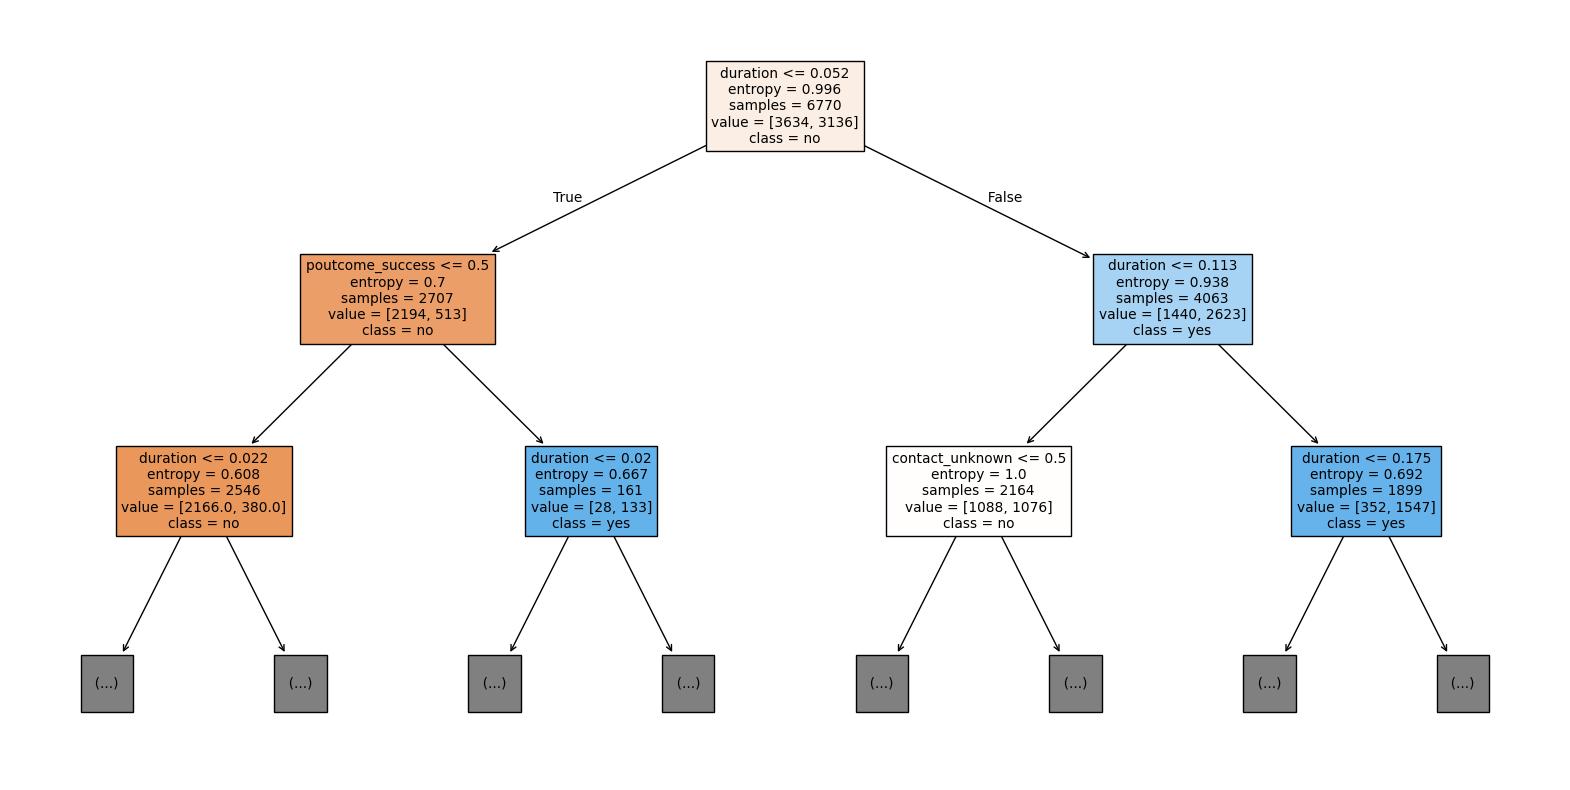

In [102]:
# Визуализация дерева (для глубины ≤ 3):
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(dtree, max_depth=2, feature_names=selected_features, class_names=['no', 'yes'], filled=True)
plt.show()

In [151]:
# Оптимизация гиперпараметров:
# Подберем max_depth, min_samples_split для борьбы с переобучением:

dtree_tuned = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6,           # Ограничение глубины
    min_samples_split=20,  # Минимальное число образцов для разделения
    random_state=42
)
dtree_tuned.fit(X_train_normalized, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=20,
                       random_state=42)

In [152]:
# Предсказание
y_pred_dtree_tuned = dtree_tuned.predict(X_test_normalized)

# Accuracy
accuracy_dtree_tuned = round(accuracy_score(y_test, y_pred_dtree_tuned), 2)
print(f"Accuracy решающего дерева: {accuracy_dtree_tuned}")

# Отчет по классификации
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred_dtree_tuned, target_names=['no', 'yes']))

Accuracy решающего дерева: 0.81

Отчет по классификации:
              precision    recall  f1-score   support

          no       0.85      0.78      0.81      1790
         yes       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



In [153]:
train_accuracy_tuned = round(accuracy_score(y_train, dtree_tuned.predict(X_train_normalized)), 2)
print(f"Accuracy решающего дерева на обучающей выборке: {train_accuracy_tuned}")

Accuracy решающего дерева на обучающей выборке: 0.82


In [104]:
# Важность признаков
importance = pd.DataFrame({
    'Признак': selected_features,
    'Важность': dtree.feature_importances_
}).sort_values('Важность', ascending=False)
print("\nВажность признаков:")
print(importance)


Важность признаков:
              Признак  Важность
1            duration  0.418688
0             balance  0.193266
13   poutcome_success  0.067719
8     contact_unknown  0.062794
2            campaign  0.053710
5   age_group_encoded  0.052822
3               pdays  0.035589
6     housing_encoded  0.027860
4            previous  0.021572
10          month_may  0.020159
9           month_mar  0.016104
11          month_oct  0.011702
7    contact_cellular  0.009309
12          month_sep  0.006337
14   poutcome_unknown  0.002369


### Задание 5 (Best_params using GridSearchCV)

In [162]:
# подберите оптимальные параметры с помощью gridsearch
# Оптимизация гиперпараметров для решающего дерева
from sklearn.model_selection import GridSearchCV
params = {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 7, 10]}
grid = GridSearchCV(dtree, params, cv=5).fit(X_train_normalized, y_train)
print(grid.best_params_)

{'max_depth': 7, 'min_samples_split': 10}


In [164]:
from sklearn.metrics import f1_score

# Лучшие параметры из GridSearchCV
best_params = grid.best_params_
print(f"Лучшие параметры: {best_params}")

# Инициализация и обучение модели с этими параметрами
optimized_dtree = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)
optimized_dtree.fit(X_train_normalized, y_train)

Лучшие параметры: {'max_depth': 7, 'min_samples_split': 10}


DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10,
                       random_state=42)

In [165]:
# Предсказание для тестовых данных
y_pred_optimized = optimized_dtree.predict(X_test_normalized)

# F1-score (усредненный по классам)
f1 = round(f1_score(y_test, y_pred_optimized, average='weighted'), 2)
print(f"F1-score на тестовой выборке: {f1}")

F1-score на тестовой выборке: 0.82


In [161]:
# Полный отчет по классификации
print("\nОтчет по классификации для оптимизированного дерева:")
print(classification_report(y_test, y_pred_optimized, target_names=['no', 'yes']))


Отчет по классификации для оптимизированного дерева:
              precision    recall  f1-score   support

          no       0.84      0.82      0.83      1790
         yes       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [166]:
# обучите на ваших данных случайный лес
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score

# Инициализация модели
rf = RandomForestClassifier(
    n_estimators=100,      # Количество деревьев
    criterion='gini',      # Критерий разделения
    min_samples_leaf=5,    # Минимальное число образцов в листе
    max_depth=10,          # Максимальная глубина дерева
    random_state=42        # Фиксация случайности
)

# Обучение на обучающей выборке
rf.fit(X_train_normalized, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [167]:
# Предсказание
y_pred_rf = rf.predict(X_test_normalized)

# Accuracy
accuracy = round(accuracy_score(y_test, y_pred_rf), 2)

# Recall (усредненный по классам)
recall = round(recall_score(y_test, y_pred_rf, average='weighted'), 2)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")

# Полный отчет по классификации
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred_rf, target_names=['no', 'yes']))

Accuracy: 0.82
Recall: 0.82

Отчет по классификации:
              precision    recall  f1-score   support

          no       0.85      0.82      0.83      1790
         yes       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



**Ключевые наблюдения**

- Случайный лес показал более высокие метрики по сравнению с одиночным решающим деревом (accuracy было 0.75, стало 0.82).
- Recall для обоих классов сбалансирован (0.82 для "no", 0.83 для "yes").

*Почему Random Forest лучше?*
- Ансамбль из 100 деревьев уменьшает переобучение и повышает обобщающую способность.
- Параметры min_samples_leaf=5 и max_depth=10 ограничивают сложность каждого дерева.

*Что говорит recall?:*
- Для класса "no": модель правильно идентифицирует 82% клиентов, которые не откроют депозит.
- Для класса "yes": находит 83% реальных случаев открытия депозита.

**Вывод:**
Случайный лес с заданными параметрами демонстрирует сбалансированное качество предсказаний для обоих классов и является улучшением по сравнению с предыдущими моделями.

### Задания 2 и 3

In [168]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score

# Инициализация модели
gb = GradientBoostingClassifier(
    learning_rate=0.05,    # Скорость обучения
    n_estimators=300,      # Количество деревьев
    min_samples_leaf=5,    # Минимальное число образцов в листе
    max_depth=5,           # Максимальная глубина дерева
    random_state=42        # Фиксация случайности
)

# Обучение на обучающей выборке
gb.fit(X_train_normalized, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=5,
                           n_estimators=300, random_state=42)

In [169]:
# Предсказание
y_pred_gb = gb.predict(X_test_normalized)

# Accuracy
accuracy = round(accuracy_score(y_test, y_pred_gb), 2)

# Recall (усредненный по классам)
recall = round(recall_score(y_test, y_pred_gb, average='weighted'), 2)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")

# Полный отчет по классификации
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred_gb, target_names=['no', 'yes']))

Accuracy: 0.83
Recall: 0.83

Отчет по классификации:
              precision    recall  f1-score   support

          no       0.85      0.82      0.84      1790
         yes       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [170]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Базовые модели
estimators = [
    ('dt', DecisionTreeClassifier(criterion='entropy', max_depth=best_params['max_depth'],
                                min_samples_split=best_params['min_samples_split'], random_state=42)),
    ('lr', LogisticRegression(solver='sag', random_state=42, max_iter=1000)),
    ('gb', GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, 
                                     min_samples_leaf=5, max_depth=5, random_state=42))
]

# Мета-модель - логистическая регрессия
stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5  # Кросс-валидация для обучения мета-модели
)

# Обучение стекинга
stacking.fit(X_train_normalized, y_train)

StackingClassifier(cv=5,
                   estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       min_samples_split=10,
                                                       random_state=42)),
                               ('lr',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression())

In [171]:
from sklearn.metrics import precision_score

# Предсказание
y_pred_stacking = stacking.predict(X_test_normalized)

# Precision (усредненный по классам)
precision = round(precision_score(y_test, y_pred_stacking, average='weighted'), 2)

print(f"Precision: {precision}")

# Полный отчет по классификации
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred_stacking, target_names=['no', 'yes']))

Precision: 0.82

Отчет по классификации:
              precision    recall  f1-score   support

          no       0.84      0.83      0.83      1790
         yes       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Сравнение с одиночными моделями:

Модель	            Precision (weighted)
- Решающее дерево	    0.82 (best_params)
- Random Forest	    0.82
- Gradient Boosting	0.83
- Stacking	        0.82


Почему стекинг эффективен?
- Комбинирует сильные стороны разных алгоритмов.
- Логистическая регрессия как мета-модель оптимально взвешивает предсказания базовых моделей.

In [172]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_stacking)
print("Матрица ошибок:")
print(cm)

Матрица ошибок:
[[1486  304]
 [ 288 1257]]


            Предсказано: no  Предсказано: yes
- Фактически: no    [1486 ---------304]
- Фактически: yes     [288 ---------1257]

True Negative (TN) = 1486 - Клиенты, которые не открыли депозит, и модель верно предсказала "no".

False Positive (FP) = 304 - Клиенты, которые не открыли депозит, но модель ошибочно предсказала "yes" (Ложноположительные).

False Negative (FN) = 288 - Клиенты, которые открыли депозит, но модель ошибочно предсказала "no" (Ложноотрицательные).

True Positive (TP) = 1257 - Клиенты, которые открыли депозит, и модель верно предсказала "yes".

**Проблемные точки модели**

*False Positive (304 случая)*
- Модель предлагает депозит клиентам, которые его не откроют.
- Последствия: Напрасные маркетинговые затраты.

*False Negative (288 случаев)*
- Модель пропускает клиентов, которые могли бы открыть депозит.
- Последствия: Потеря потенциальной прибыли.

In [173]:
stacking.final_estimator_.coef_

array([[0.64294348, 2.34000611, 3.1631576 ]])

**Градиентный бустинг — главный "двигатель" ансамбля:**
- Его предсказания в 5 раз важнее, чем у решающего дерева (3.16 / 0.64 ≈ 5).
- Это ожидаемо, так как бустинг обычно дает более точные результаты.

**Логистическая регрессия как мета-модель:**
- Несмотря на то, что она же является одной из базовых моделей, мета-модель учитывает ее предсказания отдельно.
- Вес 2.34 показывает, что она полезна, но менее важна, чем бустинг.

**Решающее дерево — слабый участник:**
- Низкий вес (0.64) говорит о том, что его предсказания содержат много шума или дублируются другими моделями.
- Возможно, его можно исключить из ансамбля без потери качества.

### Задание 5

In [175]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
# Важность признаков для градиентного бустинга (базовой модели)
top_features = pd.DataFrame({
    'Признак': selected_features,
    'Важность': stacking.estimators_[2].feature_importances_  # Индекс 2 — градиентный бустинг
}).sort_values('Важность', ascending=False).head(10)

print(top_features)

              Признак  Важность
1            duration  0.501539
13   poutcome_success  0.116203
8     contact_unknown  0.073917
0             balance  0.060586
3               pdays  0.055063
6     housing_encoded  0.046875
5   age_group_encoded  0.041819
9           month_mar  0.026098
11          month_oct  0.019117
2            campaign  0.017313


### Задания 6,7,8

In [176]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    # Задание диапазонов для гиперпараметров
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200, 1),
        'max_depth': trial.suggest_int('max_depth', 10, 30, 1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10, 1),
        'random_state': 42,
        'criterion': 'gini'
    }
    
    # Инициализация и обучение модели
    model = RandomForestClassifier(**params)
    model.fit(X_train_normalized, y_train)
    
    # Оценка качества на валидационной выборке (кросс-валидация)
    y_pred = model.predict(X_test_normalized)
    return accuracy_score(y_test, y_pred)

# Создание исследования Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Количество итераций

[I 2025-06-03 10:28:59,643] A new study created in memory with name: no-name-83eeec6e-5887-4904-8d22-05ff62e910f2
[I 2025-06-03 10:29:00,409] Trial 0 finished with value: 0.824887556221889 and parameters: {'n_estimators': 134, 'max_depth': 23, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.824887556221889.
[I 2025-06-03 10:29:01,199] Trial 1 finished with value: 0.8257871064467767 and parameters: {'n_estimators': 176, 'max_depth': 17, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8257871064467767.
[I 2025-06-03 10:29:01,723] Trial 2 finished with value: 0.8263868065967016 and parameters: {'n_estimators': 102, 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8263868065967016.
[I 2025-06-03 10:29:02,325] Trial 3 finished with value: 0.8269865067466267 and parameters: {'n_estimators': 146, 'max_depth': 12, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8269865067466267.
[I 2025-06-03 10:29:03,280] Trial 4 finished with value: 0.8251874062968516 

In [187]:
# Вывод лучших параметров
print("Лучшие параметры:", study.best_params)

# Обучение финальной модели с лучшими параметрами
best_rf = RandomForestClassifier(**study.best_params, random_state=42)
best_rf.fit(X_train_normalized, y_train)

# Оценка на тестовой выборке
y_pred_optuna = best_rf.predict(X_test_normalized)
accuracy = round(accuracy_score(y_test, y_pred_optuna), 3)

print(f"Accuracy на тестовой выборке: {accuracy}")

# Расчет F1-score (усредненный по классам)
f1 = round(f1_score(y_test, y_pred_optuna, average='weighted'), 3)

print(f"F1-score на тестовой выборке: {f1}")

Лучшие параметры: {'n_estimators': 170, 'max_depth': 19, 'min_samples_leaf': 8, 'bootstrap': False}
Accuracy на тестовой выборке: 0.831
F1-score на тестовой выборке: 0.831


In [180]:
# дополнительные метрикит - classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_optuna, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.86      0.82      0.84      1790
         yes       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



**Почему Optuna эффективнее GridSearch?**

*Интеллектуальный поиск:*
- Optuna использует методы Bayesian optimization, а не полный перебор.
- Фокусируется на перспективных областях пространства параметров.
- В примере выше проверено 50 комбинаций вместо 3×21×9=567 в GridSearch.
- Поддержка сложных распределений (например, suggest_loguniform для learning rate).

In [181]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

In [183]:
# Обновленная функция для Optuna (добавим bootstrap)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200, 1),
        'max_depth': trial.suggest_int('max_depth', 10, 30, 1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10, 1),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),  # Новый параметр
        'random_state': 42,
        'criterion': 'gini'
    }
    
    model = RandomForestClassifier(**params)
    model.fit(X_train_normalized, y_train)
    y_pred = model.predict(X_test_normalized)
    return f1_score(y_test, y_pred, average='weighted')  # Оптимизируем F1-score

In [185]:
# запуск Optuna и проверка качества

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Лучшие параметры
print("Лучшие параметры:", study.best_params)

# Обучение финальной модели
best_rf = RandomForestClassifier(**study.best_params, random_state=42)
best_rf.fit(X_train_normalized, y_train)

[I 2025-06-03 11:19:27,633] A new study created in memory with name: no-name-fa402c5f-8c26-4c73-b79e-8ccdf2b3ffeb
[I 2025-06-03 11:19:28,181] Trial 0 finished with value: 0.8265833231211589 and parameters: {'n_estimators': 120, 'max_depth': 12, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 0 with value: 0.8265833231211589.
[I 2025-06-03 11:19:28,865] Trial 1 finished with value: 0.8253521880942964 and parameters: {'n_estimators': 166, 'max_depth': 10, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 0 with value: 0.8265833231211589.
[I 2025-06-03 11:19:29,474] Trial 2 finished with value: 0.8268639909677825 and parameters: {'n_estimators': 132, 'max_depth': 13, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 2 with value: 0.8268639909677825.
[I 2025-06-03 11:19:30,489] Trial 3 finished with value: 0.8272049695234243 and parameters: {'n_estimators': 190, 'max_depth': 28, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 3 with value: 0.8272049695234243

Лучшие параметры: {'n_estimators': 170, 'max_depth': 19, 'min_samples_leaf': 8, 'bootstrap': False}


RandomForestClassifier(bootstrap=False, max_depth=19, min_samples_leaf=8,
                       n_estimators=170, random_state=42)

In [188]:
# F1-score на тестовой выборке
y_pred_optuna = best_rf.predict(X_test_normalized)
f1 = round(f1_score(y_test, y_pred_optuna, average='weighted'), 3)
print(f"F1-score на тестовой выборке с bootstrap: {f1}")

# Accuracy на тестовой выборке
accuracy = round(accuracy_score(y_test, y_pred_optuna), 3)
print(f"Accuracy на тестовой выборке с bootstrap: {accuracy}")

F1-score на тестовой выборке с bootstrap: 0.831
Accuracy на тестовой выборке с bootstrap: 0.831


Как видим, при оптимизации через Optuna (после применения bootstrap) наши метрики не изменились и остались равны 0.831